**Trabalho de Webscraping - LEA**



Nome: Luiza Neves Graça

RA: 791328

In [23]:
!pip install kneed

In [51]:
# pacotes:

# geral
import pandas as pd
import numpy as np

# webscraping
import requests
from bs4 import BeautifulSoup

# análise descritiva
import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# salvar dados em json
from google.colab import files
import os
import json

# Webscraping

Para a primeira parte deste trabalho, foram extraídos dados de empresas de capital aberto listadas na bolsa brasileira (B3) a partir do site https://www.fundamentus.com.br/.

In [2]:
url = 'https://www.fundamentus.com.br/detalhes.php?papel=' # url com a tabela de todas as empresas contidas neste site

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36"
}

In [3]:
response = requests.get(url, headers=headers)
response

<Response [200]>

In [4]:
soup = BeautifulSoup(response.text, "html.parser")
soup # código html da página

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">

<html lang="pt-br">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<title>FUNDAMENTUS - Invista consciente - Indicadores Fundamentalistas</title>
<link href="css/estilo.css" media="screen, projection" rel="stylesheet" type="text/css"/>
<link href="css/print.css" media="print" rel="stylesheet" type="text/css"/>
<link href="img/fundamentus.ico" rel="shortcut icon" type="image/x-icon"/>
<!--[if lte IE 6]>
		<link rel="stylesheet" type="text/css" href="css/menu_ie6.css">
		<script type="text/javascript" src="script/ADxMenu.js"></script>
	<![endif]-->
<!-- <script src="script/mootools.svn.js" type="text/javascript"></script>  -->
<script src="//ajax.googleapis.com/ajax/libs/mootools/1.11/mootools-yui-compressed.js" type="text/javascript"></script>
<!-- Facebook Pixel Code -->
<script>
  !function(f,b,e,v,n,t,s)
  {if(f.fbq)return;n=f.fbq=function(){n.callMethod?
  n.callM

No código acima, vemos que as informações estão dispostas em uma tabela (table) e tem como classe a string 'resultado', como pode ser visto neste trecho do código: '<table id="test1" class="resultado [...]'.

In [5]:
lista = soup.find('table', {'class': 'resultado'})
lista

<table border="0" cellpadding="0" cellspacing="0" class="resultado sortable-onload-&lt;? echo rand(0,2); ?&gt;-reverse rowstyle-par colstyle-col no-arrow" id="test1">
<thead>
<tr>
<th class="fd-column-0 sortable-text reverseSort" style="-moz-user-select: none;"><a href="#">Papel</a></th>
<th class="sortable-text fd-column-1" style="-moz-user-select: none;"><a href="#">Nome Comercial</a></th>
<th class="sortable-text fd-column-2" style="-moz-user-select: none;"><a href="#">Razão Social</a></th>
</tr>
</thead>
<tbody>
<tr class="">
<td><a href="detalhes.php?papel=AALR3 ">AALR3 </a></td>
<td>ALLIAR</td>
<td>CENTRO DE IMAGEM DIAGNOSTICOS S.A.</td>
</tr>
<tr class="par">
<td><a href="detalhes.php?papel=ABCB3">ABCB3</a></td>
<td>ABC Brasil</td>
<td>BANCO ABC BRASIL S/A</td>
</tr>
<tr class="">
<td><a href="detalhes.php?papel=ABCB4">ABCB4</a></td>
<td>ABC Brasil</td>
<td>BANCO ABC BRASIL S/A</td>
</tr>
<tr class="par">
<td><a href="detalhes.php?papel=ABEV3">ABEV3</a></td>
<td>AMBEV S/A</td>
<

In [6]:
linhas = lista.find('tbody').find_all('tr')
linhas # extrai todas as linhas da tabela do site e as armazenam nesta lista

[<tr class="">
 <td><a href="detalhes.php?papel=AALR3 ">AALR3 </a></td>
 <td>ALLIAR</td>
 <td>CENTRO DE IMAGEM DIAGNOSTICOS S.A.</td>
 </tr>,
 <tr class="par">
 <td><a href="detalhes.php?papel=ABCB3">ABCB3</a></td>
 <td>ABC Brasil</td>
 <td>BANCO ABC BRASIL S/A</td>
 </tr>,
 <tr class="">
 <td><a href="detalhes.php?papel=ABCB4">ABCB4</a></td>
 <td>ABC Brasil</td>
 <td>BANCO ABC BRASIL S/A</td>
 </tr>,
 <tr class="par">
 <td><a href="detalhes.php?papel=ABEV3">ABEV3</a></td>
 <td>AMBEV S/A</td>
 <td>AMBEV S.A.</td>
 </tr>,
 <tr class="">
 <td><a href="detalhes.php?papel=ABRE3">ABRE3</a></td>
 <td>SOMOS EDUCA</td>
 <td>SOMOS EDUCAÇÃO S.A.</td>
 </tr>,
 <tr class="par">
 <td><a href="detalhes.php?papel=ABYA3">ABYA3</a></td>
 <td>ABYARA</td>
 <td>ABYARA PLANEJAMENTO IMOBILIARIO S.A.</td>
 </tr>,
 <tr class="">
 <td><a href="detalhes.php?papel=ACES3">ACES3</a></td>
 <td>ARCELORMITTAL INOX BRASIL</td>
 <td>ARCELORMITTAL INOX BRASIL S.A.</td>
 </tr>,
 <tr class="par">
 <td><a href="detalhes.ph

In [7]:
tickers = [] # cria uma lista de listas contendo o nome (ticker) da ação e o url do site específico para cada ação
for linha in linhas:
    ticker_link = linha.find('td').find('a')
    ticker_text = ticker_link.text.strip()
    ticker_url = ticker_link['href']

    tickers.append({
        'ticker': ticker_text,
        'url': f'https://www.fundamentus.com.br/{ticker_url.strip()}' # já cria o link completo
    })

tickers

[{'ticker': 'AALR3',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=AALR3'},
 {'ticker': 'ABCB3',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=ABCB3'},
 {'ticker': 'ABCB4',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=ABCB4'},
 {'ticker': 'ABEV3',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=ABEV3'},
 {'ticker': 'ABRE3',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=ABRE3'},
 {'ticker': 'ABYA3',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=ABYA3'},
 {'ticker': 'ACES3',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=ACES3'},
 {'ticker': 'ACES4',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=ACES4'},
 {'ticker': 'ADHM3',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=ADHM3'},
 {'ticker': 'AEDU11',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=AEDU11'},
 {'ticker': 'AEDU3',
  'url': 'https://www.fundamentus.com.br/detalhes.php?papel=AEDU3'},
 {'ticke

## Extraindo informações para uma única empresa

Primeiramente, iremos explorar como obter as informações para uma única empresa para, posteriormente, generalizarmos as técnicas encontradas para todas.

In [8]:
response = requests.get([ticker['url'] for ticker in tickers][0], headers=headers) # primeira ação da lista
soup = BeautifulSoup(response.text, "html.parser")
soup

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">

<html lang="pt-br">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<title>FUNDAMENTUS - AALR3 - Invista consciente - Indicadores Fundamentalistas</title>
<link href="css/estilo.css" media="screen, projection" rel="stylesheet" type="text/css"/>
<link href="css/print.css" media="print" rel="stylesheet" type="text/css"/>
<link href="img/fundamentus.ico" rel="shortcut icon" type="image/x-icon"/>
<!--[if lte IE 6]>
		<link rel="stylesheet" type="text/css" href="css/menu_ie6.css">
		<script type="text/javascript" src="script/ADxMenu.js"></script>
	<![endif]-->
<!-- <script src="script/mootools.svn.js" type="text/javascript"></script>  -->
<script src="//ajax.googleapis.com/ajax/libs/mootools/1.11/mootools-yui-compressed.js" type="text/javascript"></script>
<!-- Facebook Pixel Code -->
<script>
  !function(f,b,e,v,n,t,s)
  {if(f.fbq)return;n=f.fbq=function(){n.callMethod?
 

Vale notar que os dados da companhia estão dispostos em tabelas, tal que estas são organizadas da seguinte forma:

In [9]:
tables = soup.find_all("table")
print(tables[0]) # tabela com nome, setor, cotação, volume...
print('\n---\n')
print(tables[1]) # tabela com valor de mercado, valor da firma, # de ações..
print('\n---\n')
print(tables[2]) # tabela com oscilações e indicadores fundamentalistas
print('\n---\n')
print(tables[3]) # tabela com dados do balanço patrimonial
print('\n---\n')
print(tables[4]) # tabela com dados da dre

<table class="w728">
<tr>
<td class="label w15"><span class="help tips" title="Código da ação">?</span><span class="txt">Papel</span></td>
<td class="data w35"><span class="txt">AALR3</span></td>
<td class="label destaque w2"><span class="help tips" title="Cotação de fechamento da ação no último pregão">?</span><span class="txt">Cotação</span></td>
<td class="data destaque w3"><span class="txt">8,80</span></td>
</tr>
<tr>
<td class="label"><span class="help tips" title="ON = Ordinária, PN = Preferencial, PNA = Pref. tipo A, etc">?</span><span class="txt">Tipo</span></td>
<td class="data"><span class="txt">ON NM</span></td>
<td class="label"><span class="help tips" title="Data do último pregão em  que o ativo foi negociado">?</span><span class="txt">Data últ cot</span></td>
<td class="data"><span class="txt">27/12/2024</span></td>
</tr>
<tr>
<td class="label"><span class="help tips" title="Nome comercial da empresa.">?</span><span class="txt">Empresa</span></td>
<td class="data"><span c

Quero extrair os dados sobre: Vol $ méd (2m), Setor, Subsetor, Valor de mercado, Valor da firma, as oscilações no preço nos prazos de um dia, um mês, 30 dias, 12 meses, em 2024 e em 2023, além dos indicadores de Preço/Valor Patrimonial (P/VP), Preço/Lucro (P/L), Retorno sobre investimento (ROE), Margem Bruta, Margem EBIT, Dívida Bruta/Patrimônio, Patrimônio Líquido, Dívida Líquida, Dívida Bruta, Receita Líquida no último ano e no último trimestre e Lucro Líquido no último ano e no último trimestre,

In [10]:
infos = ['Papel', 'Setor', 'Subsetor','Vol $ méd (2m)',
        'Valor de mercado', 'Valor da firma', 'Dia',
        'Mês', '30 dias', '12 meses', '2024', '2023',
        'P/L', 'P/VP', 'ROE', 'Marg. Bruta', 'Marg. Líquida',
        'Marg. EBIT', 'Div Br/ Patrim', 'Dív. Líquida',
        'Patrim. Líq', 'Receita Líquida 12 meses',
         'Receita Líquida 3 meses', 'Lucro Líquido 12 meses',
         'Lucro Líquido 3 meses']

In [11]:
for info in infos:
    label = soup.find('span', text=info)
    if label:
        valor = label.find_next('td', class_='data')
        print(f"{info}: {valor.get_text(strip=True)}")
    else:
      print(f"{info}: ERRO")

Papel: AALR3
Setor: Serv.Méd.Hospit. Análises e Diagnósticos
Subsetor: Serv.Méd.Hospit. Análises e Diagnósticos
Vol $ méd (2m): 222.497
Valor de mercado: 1.040.980.000
Valor da firma: 1.608.250.000
Dia: 0,00%
Mês: -26,67%


<ipython-input-11-c419271cc3d2>:2: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  label = soup.find('span', text=info)


30 dias: -30,71%
12 meses: -13,81%
2024: -15,38%
2023: -51,85%
P/L: -6,31
P/VP: 0,91
ROE: -14,4%
Marg. Bruta: 30,4%
Marg. Líquida: -12,9%
Marg. EBIT: 6,5%
Div Br/ Patrim: 0,64
Dív. Líquida: 567.271.000
Patrim. Líq: 1.147.410.000
Receita Líquida 12 meses: ERRO
Receita Líquida 3 meses: ERRO
Lucro Líquido 12 meses: ERRO
Lucro Líquido 3 meses: ERRO


Não foi possível obter as inforções sobre a receita líquida e o lucro líquido desta forma. Assim, tentaremos de outro modo, utilizando a tabela específica em que estas informações estão.

In [12]:
linhas = tables[4].find_all("tr")
# queremos a terceira e quinta linhas (receita líquida e lucro líquido)
celulas = linhas[2].find_all("td") # o td marca o começo e final de cada célula da tabela
# as linhas tem 4 células sendo que a segunda célula marca o valor de 12 meses e a quarta marca o valor de 3 meses
print(f'Receita Líquida 12 meses: {celulas[1].get_text(strip=True)}')
print(f'Receita Líquida 3 meses: {celulas[3].get_text(strip=True)}')
# lucro
celulas = linhas[4].find_all("td")
print(f'Lucro Líquido 12 meses: {celulas[1].get_text(strip=True)}')
print(f'Lucro Líquido 3 meses: {celulas[3].get_text(strip=True)}')

Receita Líquida 12 meses: 1.204.510.000
Receita Líquida 3 meses: 317.879.000
Lucro Líquido 12 meses: -164.865.000
Lucro Líquido 3 meses: 1.804.000


Comparando com os dados do site, temos que todas as informações foram extraídas corretamente. Conforme pode ser observado na figura abaixo:

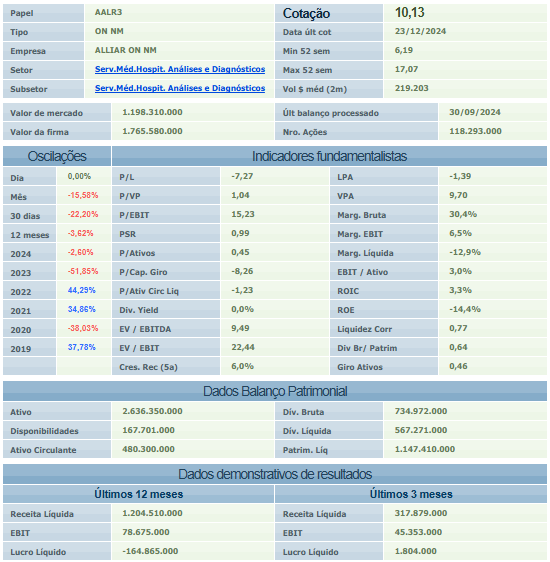

## Extraindo informações para todas as empresas

Agora que sabemos como obter as informações para uma empresa, iremos generalizar para obter as informações de todas.

In [13]:
df = pd.DataFrame(columns=infos)

for ticker in tickers:
  try:
    # cada ticker (empresa) é uma linha
    response = requests.get(ticker['url'], headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    tables = soup.find_all("table")
    dados = {} # armazena os dados da linha
    for info in infos[:-4]:
      label = soup.find('span', text=info)
      if label:
          valor = label.find_next('td', class_='data')
          dados[info] = valor.get_text(strip=True)
    linhas = tables[4].find_all("tr")
    # receita
    celulas = linhas[2].find_all("td")
    dados[infos[-4]] = celulas[1].get_text(strip=True)
    dados[infos[-3]] = celulas[3].get_text(strip=True)
    # lucro
    celulas = linhas[4].find_all("td")
    dados[infos[-2]] = celulas[1].get_text(strip=True)
    dados[infos[-1]] = celulas[3].get_text(strip=True)
    # adicionar linha ao dataframe
    df = pd.concat([df, pd.DataFrame([dados], columns=df.columns)], ignore_index=True)
  # nem todos os links estão funcionando (o try/except ajuda a driblar isso)
  except requests.exceptions.RequestException as e:
    # pega erros no request (como problemas de conexão, 404/500)
    print(f"Não foi possível obter dados de {ticker['url']}: {e}")
  except Exception as e:
    # pega outros erros (caso o link não leve a lugar nenhum, por exemplo)
    print(f"Erro ao processar {ticker['url']}: {e}")

df.head()

<ipython-input-13-8cc8a7b6f1ae>:11: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  label = soup.find('span', text=info)


Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=ABRE3: list index out of range
Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=ALSO3: list index out of range
Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=AORE3: list index out of range
Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=ARZZ3: list index out of range
Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=ASAI3: list index out of range
Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=AURA32: list index out of range
Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=BAHI3: list index out of range
Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=BBRK3: list index out of range
Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=BKBR3: list index out of range
Erro ao processar https://www.fundamentus.com.br/detalhes.php?papel=BPNM4: list index out of range
Erro ao p

Papel                                     Setor  \
0  AALR3  Serv.Méd.Hospit. Análises e Diagnósticos   
1  ABCB3                Intermediários Financeiros   
2  ABCB4                Intermediários Financeiros   
3  ABEV3                                   Bebidas   
4  ABYA3                          Construção Civil   

                                   Subsetor Vol $ méd (2m) Valor de mercado  \
0  Serv.Méd.Hospit. Análises e Diagnósticos        222.497    1.040.980.000   
1                                    Bancos              0                0   
2                                    Bancos     16.857.600    5.076.630.000   
3                  Cervejas e Refrigerantes    477.091.000  190.195.000.000   
4                             Incorporações              0      515.088.000   

    Valor da firma     Dia      Mês  30 dias 12 meses  ... Marg. Bruta  \
0    1.608.250.000   0,00%  -26,67%  -30,71%  -13,81%  ...       30,4%   
1                -   0,00%    0,00%    0,00%    0,00%  ...           -   
2                -   0,39%    2,57%   -2,12%   -8,31%  ...           -   
3  172.636.000.000  -0,58%   -0,27%    0,68%   -7,80%  ...       51,0%   
4      868.691.000   0,00%    0,00%    0,00%    0,00%  ...       32,0%   

  Marg. Líquida Marg. EBIT Div Br/ Patrim     Dív. Líquida     Patrim. Líq  \
0        -12,9%       6,5%           0,64      567.271.000   1.147.410.000   
1          0,0%          -              -              NaN   6.378.310.000   
2          0,0%          -              -              NaN   6.378.310.000   
3         17,4%      21,3%           0,03  -17.558.800.000  98.140.400.000   
4         -1,0%      10,3%           1,31      353.603.000     292.060.000   

  Receita Líquida 12 meses Receita Líquida 3 meses Lucro Líquido 12 meses  \
0            1.204.510.000             317.879.000           -164.865.000   
1            1.485.230.000             428.146.000            959.666.000   
2            1.485.230.000             428.146.000            959.666.000   
3           82.406.500.000          22.096.700.000         13.944.500.000   
4              250.657.000              67.990.000             -2.398.000   

  Lucro Líquido 3 meses  
0             1.804.000  
1           255.070.000  
2           255.070.000  
3         3.460.270.000  
4              -766.000  

[5 rows x 25 columns]

Como podemos ver na segunda e na quinta linhas do dataframe, nem todas os papéis inclusos são ativamente negociados. Papéis que não são negociados são marcados por um volume médio nulo (Vol $ méd (2m)). Assim, iremos excluir as linhas que não possuem negócios para que isto não interfira nas análises posteriores. Ademais, também serão excluídos papéis que, apesar de ainda serem negociados, não tiveram negócios no último mês.

Antes disso, no entanto, o dataframe deve ser organizado de modo que todos os valores sejam lidos como número ou string respectivamente.

In [14]:
print(df.dtypes)
# pode ser que números estejam sendo armazenados como string
# ademais, vemos acima que as strings possuem caracteres especiais como %,.- que precisam ser limpados

Papel                       object
Setor                       object
Subsetor                    object
Vol $ méd (2m)              object
Valor de mercado            object
Valor da firma              object
Dia                         object
Mês                         object
30 dias                     object
12 meses                    object
2024                        object
2023                        object
P/L                         object
P/VP                        object
ROE                         object
Marg. Bruta                 object
Marg. Líquida               object
Marg. EBIT                  object
Div Br/ Patrim              object
Dív. Líquida                object
Patrim. Líq                 object
Receita Líquida 12 meses    object
Receita Líquida 3 meses     object
Lucro Líquido 12 meses      object
Lucro Líquido 3 meses       object
dtype: object


In [15]:
df2 = df
for col in df2.columns[3:]:
  df2[col] = df2[col].astype(str)
  df2[col] = df2[col].str.replace('%', '', regex=False)  # Remove '%'
  df2[col] = df2[col].str.replace('.', '', regex=False) # tira os '.' (milhar)
  df2[col] = df2[col].str.replace(',', '.', regex=False)  # Substitui ',' por '.' (decimal)
  df2[col] = df2[col].replace('nan', None)  # Substitui "nan" (string) por None
  df2[col] = df2[col].replace('-', np.nan) # caso o valor de toda a cécula seja '-' substitua por NaN
  df2[col] = pd.to_numeric(df2[col])
df2.head()

Papel                                     Setor  \
0  AALR3  Serv.Méd.Hospit. Análises e Diagnósticos   
1  ABCB3                Intermediários Financeiros   
2  ABCB4                Intermediários Financeiros   
3  ABEV3                                   Bebidas   
4  ABYA3                          Construção Civil   

                                   Subsetor  Vol $ méd (2m)  Valor de mercado  \
0  Serv.Méd.Hospit. Análises e Diagnósticos          222497        1040980000   
1                                    Bancos               0                 0   
2                                    Bancos        16857600        5076630000   
3                  Cervejas e Refrigerantes       477091000      190195000000   
4                             Incorporações               0         515088000   

   Valor da firma   Dia    Mês  30 dias  12 meses  ...  Marg. Bruta  \
0    1.608250e+09  0.00 -26.67   -30.71    -13.81  ...         30.4   
1             NaN  0.00   0.00     0.00      0.00  ...          NaN   
2             NaN  0.39   2.57    -2.12     -8.31  ...          NaN   
3    1.726360e+11 -0.58  -0.27     0.68     -7.80  ...         51.0   
4    8.686910e+08  0.00   0.00     0.00      0.00  ...         32.0   

   Marg. Líquida  Marg. EBIT  Div Br/ Patrim  Dív. Líquida  Patrim. Líq  \
0          -12.9         6.5            0.64  5.672710e+08   1147410000   
1            0.0         NaN             NaN           NaN   6378310000   
2            0.0         NaN             NaN           NaN   6378310000   
3           17.4        21.3            0.03 -1.755880e+10  98140400000   
4           -1.0        10.3            1.31  3.536030e+08    292060000   

   Receita Líquida 12 meses  Receita Líquida 3 meses  Lucro Líquido 12 meses  \
0                1204510000                317879000              -164865000   
1                1485230000                428146000               959666000   
2                1485230000                428146000               959666000   
3               82406500000              22096700000             13944500000   
4                 250657000                 67990000                -2398000   

   Lucro Líquido 3 meses  
0                1804000  
1              255070000  
2              255070000  
3             3460270000  
4                -766000  

[5 rows x 25 columns]

In [16]:
# remover empresas que não são negociadas
df2 = df2[df2.iloc[:, 3] != 0]

# remover empresas que não tiveram negócios no último mês também (apesar de ainda serem negociadas)
df2 = df2[df2.iloc[:, 7] != 0] # mês
df2 = df2[df2.iloc[:, 8] != 0] # 30 dias
df2.head()

Papel                                     Setor  \
0   AALR3  Serv.Méd.Hospit. Análises e Diagnósticos   
2   ABCB4                Intermediários Financeiros   
3   ABEV3                                   Bebidas   
11  AERI3                   Máquinas e Equipamentos   
15  AFLT3                          Energia Elétrica   

                                    Subsetor  Vol $ méd (2m)  \
0   Serv.Méd.Hospit. Análises e Diagnósticos          222497   
2                                     Bancos        16857600   
3                   Cervejas e Refrigerantes       477091000   
11                 Máq. e Equip. Industriais         4740510   
15                          Energia Elétrica            2465   

    Valor de mercado  Valor da firma   Dia    Mês  30 dias  12 meses  ...  \
0         1040980000    1.608250e+09  0.00 -26.67   -30.71    -13.81  ...   
2         5076630000             NaN  0.39   2.57    -2.12     -8.31  ...   
3       190195000000    1.726360e+11 -0.58  -0.27     0.68     -7.80  ...   
11         516219000    1.088280e+09 -0.12  56.50    47.34    -57.60  ...   
15         460521000    4.393820e+08  6.73   4.91     8.62     -7.14  ...   

    Marg. Bruta  Marg. Líquida  Marg. EBIT  Div Br/ Patrim  Dív. Líquida  \
0          30.4          -12.9         6.5            0.64  5.672710e+08   
2           NaN            0.0         NaN             NaN           NaN   
3          51.0           17.4        21.3            0.03 -1.755880e+10   
11         15.1           -8.8         7.4            1.40  5.720590e+08   
15         58.1           41.2        54.0             NaN -2.113900e+07   

    Patrim. Líq  Receita Líquida 12 meses  Receita Líquida 3 meses  \
0    1147410000                1204510000                317879000   
2    6378310000                1485230000                428146000   
3   98140400000               82406500000              22096700000   
11   1037680000                1564970000                367434000   
15    247459000                  54808000                 20677000   

    Lucro Líquido 12 meses  Lucro Líquido 3 meses  
0               -164865000                1804000  
2                959666000              255070000  
3              13944500000             3460270000  
11              -137587000              -56678000  
15                22593000                6062000  

[5 rows x 25 columns]

In [17]:
print("Valores nulos por coluna:")
print((df2 == 0).sum())

Valores nulos por coluna:
Papel                        0
Setor                        0
Subsetor                     0
Vol $ méd (2m)               0
Valor de mercado             0
Valor da firma               0
Dia                         65
Mês                          0
30 dias                      0
12 meses                     0
2024                         0
2023                         2
P/L                          1
P/VP                         5
ROE                          0
Marg. Bruta                  0
Marg. Líquida               43
Marg. EBIT                   0
Div Br/ Patrim               3
Dív. Líquida                 6
Patrim. Líq                  4
Receita Líquida 12 meses    10
Receita Líquida 3 meses     14
Lucro Líquido 12 meses       1
Lucro Líquido 3 meses        5
dtype: int64


Note que algumas empresas possuem alguns valores faltantes, como o caso do banco ABC (ABCB4), na segunda linha do dataframe. Isto se dá por conta das próprias características contábeis do setor bancário que diferem de outros setores (por exemplo, não existem linhas de dívida no balanço patrimonial de bancos). Desse modo, vale destacar que os valores faltantes não representam uma falha na coleta dos dados e sim uma característica de certas empresas.

No entanto, para análises posteriores, a presença de NAs é prejudicial e impede o ajuste dos modelos e, assim, foi optado por remover linhas com valores ausentes da análise.

In [ ]:
# é necessário remover linhas com valores ausentes
df_limpo = df2.dropna()
print(df_limpo.shape)
df_limpo.head()

In [30]:
# verificar se tudo está ok
print("Dimensões do dataframe:", df_limpo.shape)
print("\nNúmero de valores ausentes por coluna")
print(df_limpo.isna().sum())
print("Índices duplicados:", df_limpo.index.duplicated().sum())

Dimensões do dataframe: (328, 26)

Número de valores ausentes por coluna
Papel                       0
Setor                       0
Subsetor                    0
Vol $ méd (2m)              0
Valor de mercado            0
Valor da firma              0
Dia                         0
Mês                         0
30 dias                     0
12 meses                    0
2024                        0
2023                        0
P/L                         0
P/VP                        0
ROE                         0
Marg. Bruta                 0
Marg. Líquida               0
Marg. EBIT                  0
Div Br/ Patrim              0
Dív. Líquida                0
Patrim. Líq                 0
Receita Líquida 12 meses    0
Receita Líquida 3 meses     0
Lucro Líquido 12 meses      0
Lucro Líquido 3 meses       0
Cluster                     0
dtype: int64
Índices duplicados: 0


In [32]:
#pasta = "data"
#arquivo = os.path.join(pasta, "dados.json")

#os.makedirs(pasta, exist_ok=True)

#df_limpo.to_json(arquivo, orient="records", indent=4)

#files.download(arquivo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Análise descritiva e exploratória

Nesta parte, foram observados o comportamento de cada variável bem como a presença de outliers.

In [33]:
print("Resumo estatístico geral:\n")
print(df_limpo.describe().applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x))

Resumo estatístico geral:

         Vol $ méd (2m)    Valor de mercado      Valor da firma     Dia  \
count            328.00              328.00              328.00  328.00   
mean      49,218,034.88   12,800,413,490.00   19,283,740,726.04    0.36   
std      133,800,904.77   45,110,639,427.75   63,992,929,404.83    3.32   
min              118.00        3,213,000.00     -629,156,000.00  -14.29   
25%           77,980.75      394,848,750.00      777,048,500.00   -0.87   
50%        2,981,470.00    1,832,615,000.00    3,448,995,000.00    0.00   
75%       40,163,425.00    8,441,147,500.00   14,090,900,000.00    0.86   
max    1,293,210,000.00  506,648,000,000.00  750,967,000,000.00   31.00   

          Mês 30 dias 12 meses    2024    2023       P/L  ... Marg. Líquida  \
count  328.00  328.00   328.00  328.00  328.00    328.00  ...        328.00   
mean    -5.85   -9.85   -13.78  -14.28   29.67     16.72  ...         71.40   
std     13.82   15.24    55.95   58.59   86.19    147.34  ..

<ipython-input-33-5fd2b4826853>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df_limpo.describe().applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x))


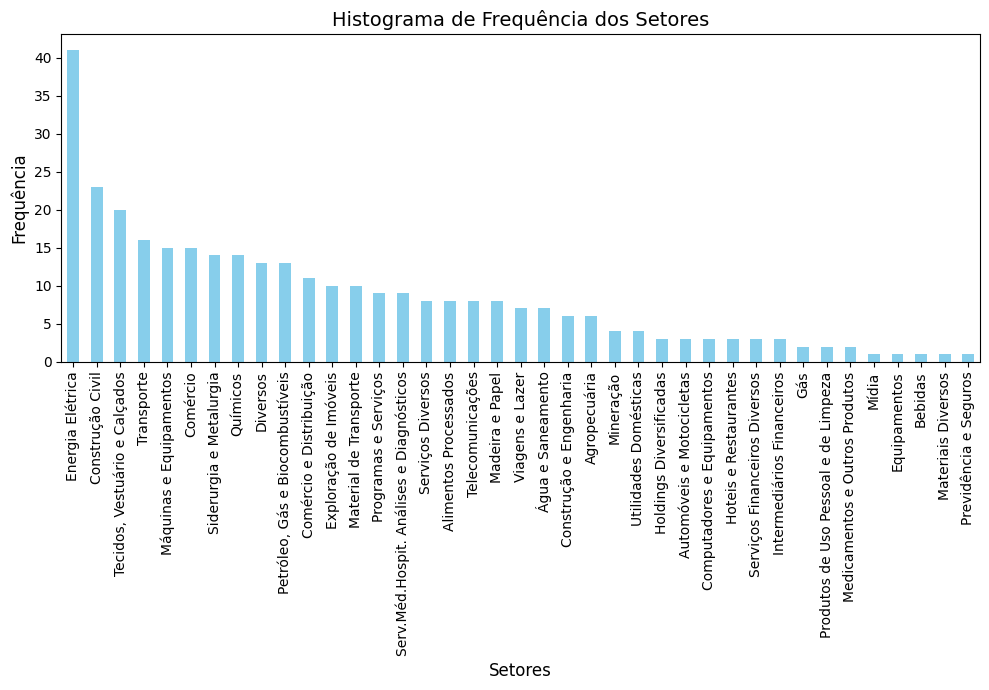

In [34]:
frequencia = df_limpo['Setor'].value_counts()

plt.figure(figsize=(10, 7))
frequencia.plot(kind='bar', color='skyblue')

plt.title('Histograma de Frequência dos Setores', fontsize=14)
plt.xlabel('Setores', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

plt.tight_layout()
plt.show()

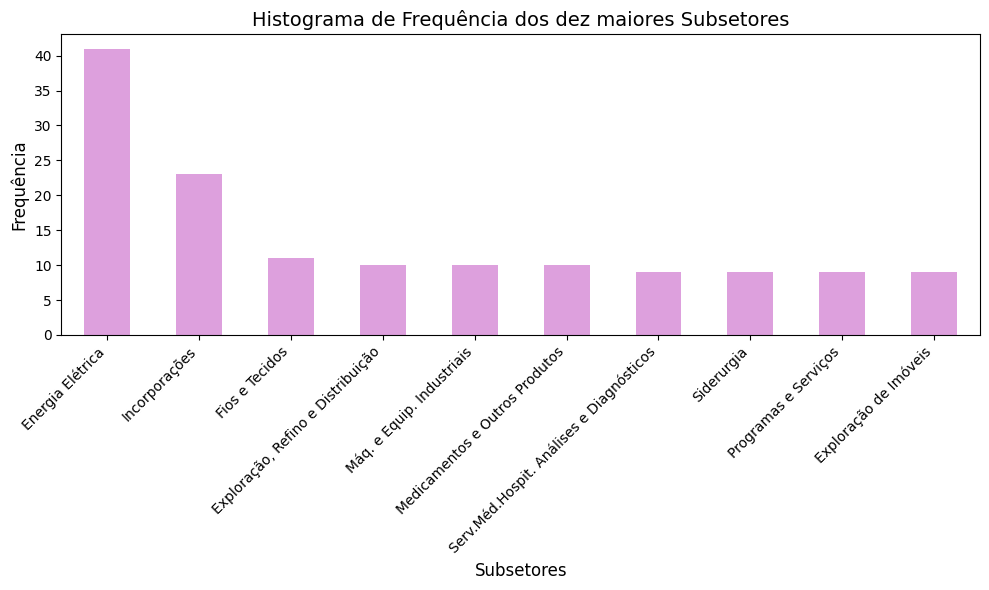

In [36]:
frequencia = df_limpo['Subsetor'].value_counts()

plt.figure(figsize=(10, 6))
frequencia[:10].plot(kind='bar', color='plum')

plt.title('Histograma de Frequência dos dez maiores Subsetores', fontsize=14)
plt.xlabel('Subsetores', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()

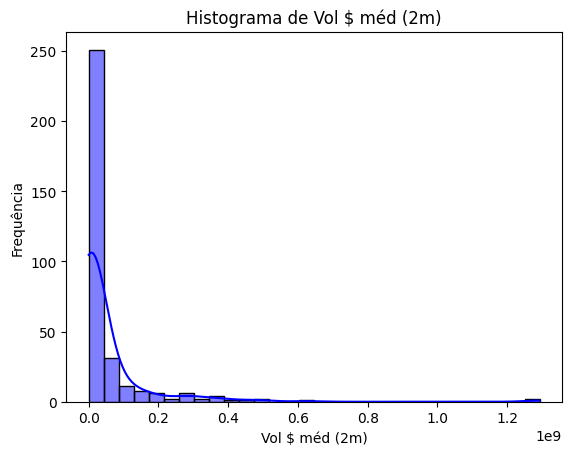

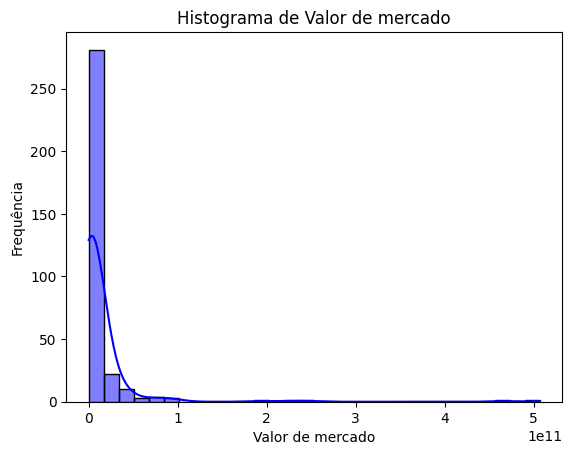

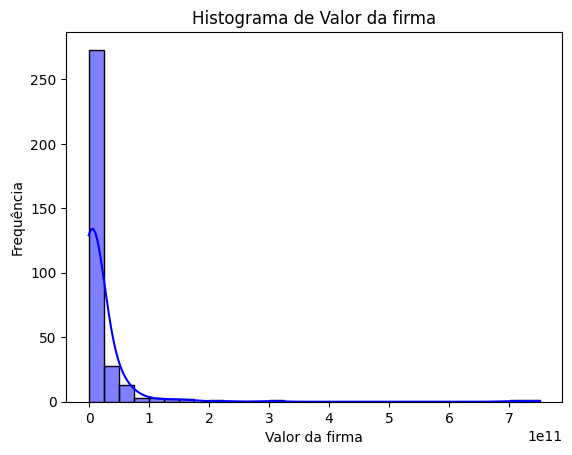

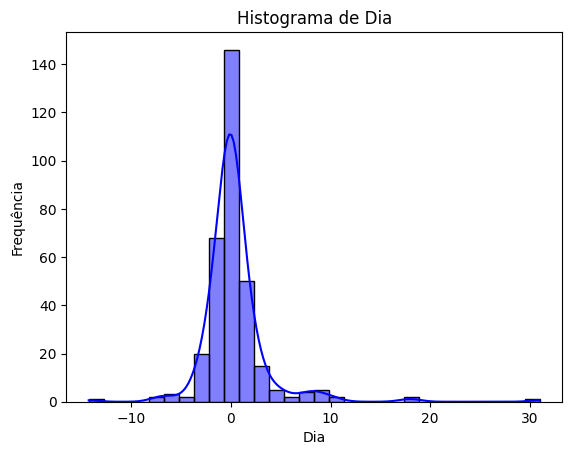

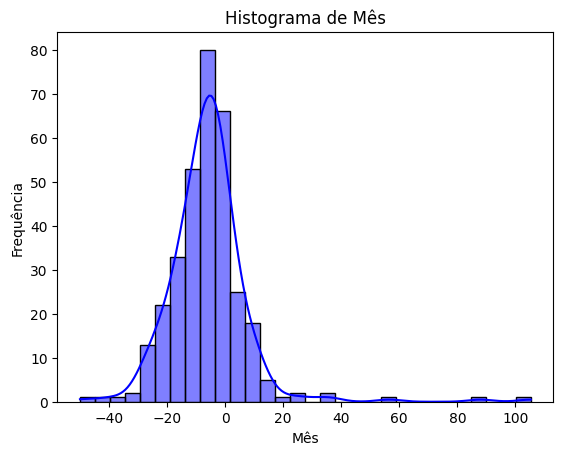

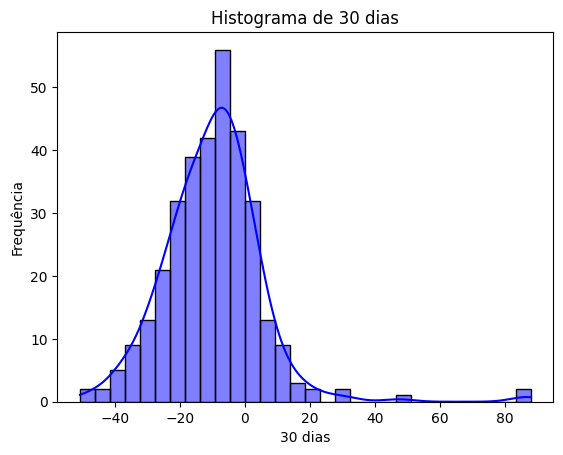

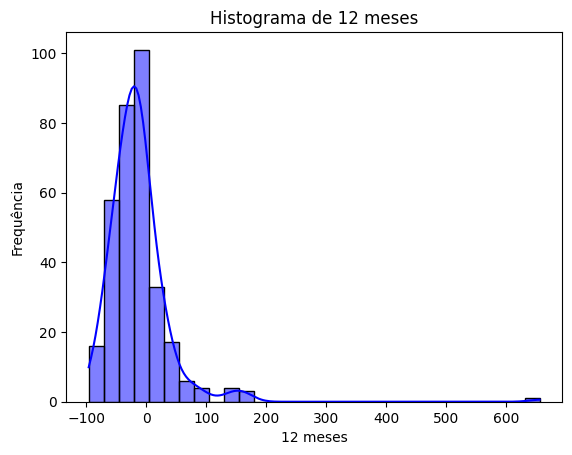

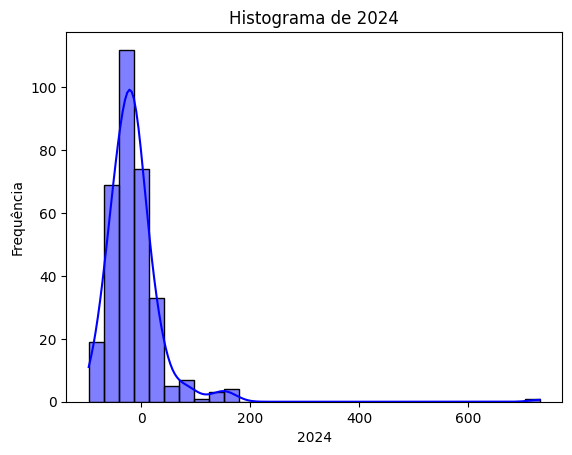

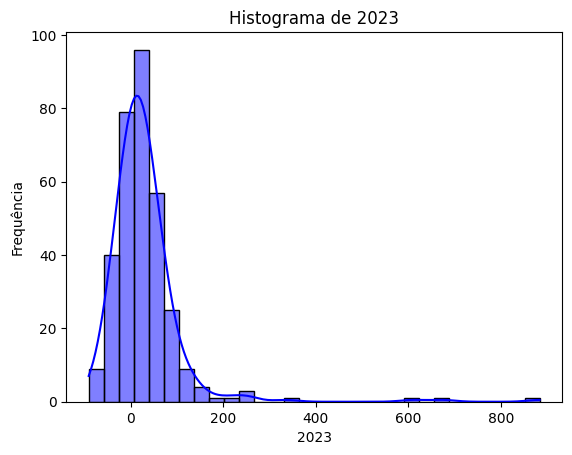

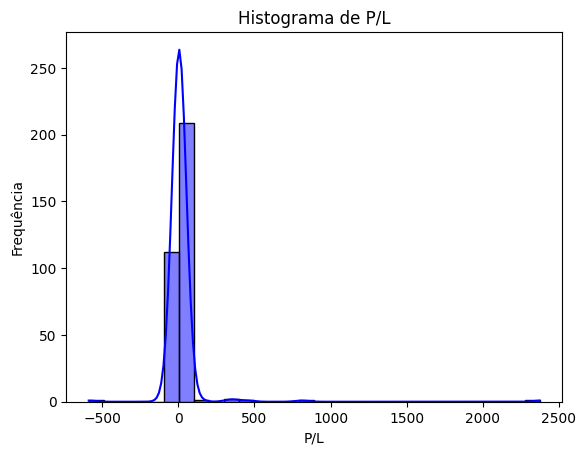

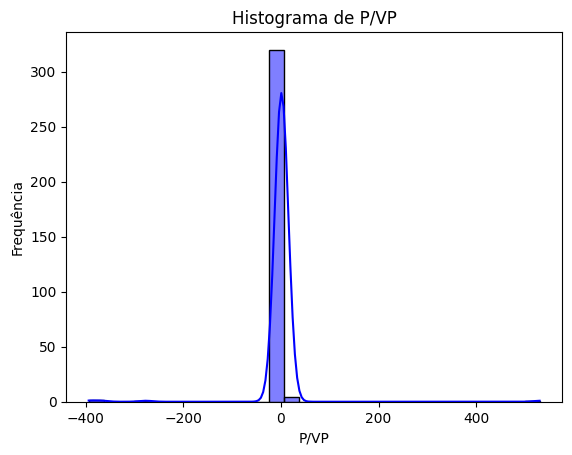

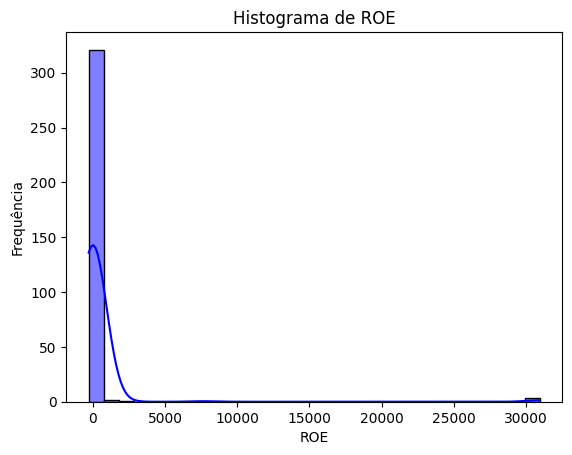

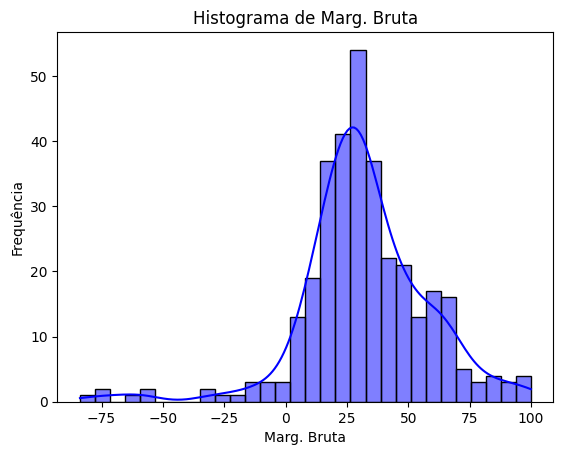

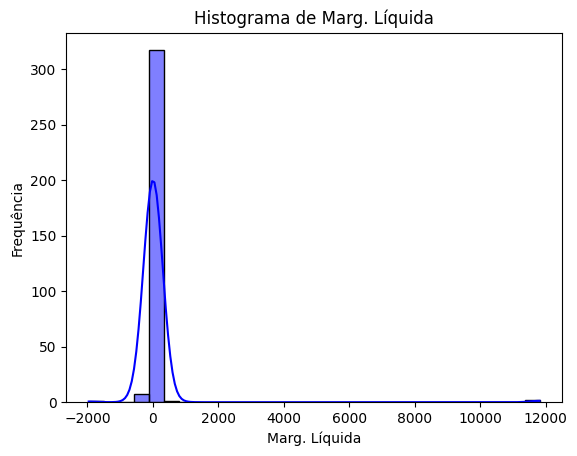

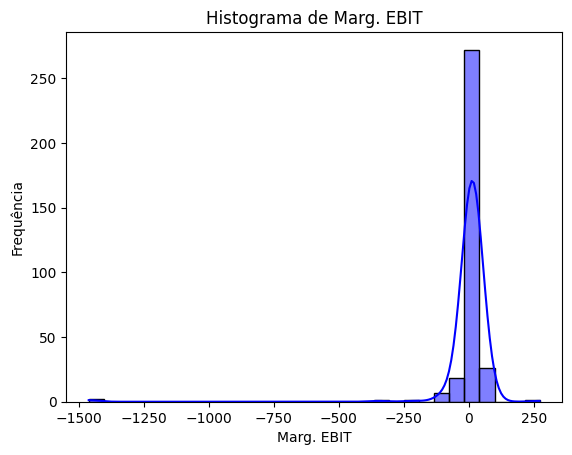

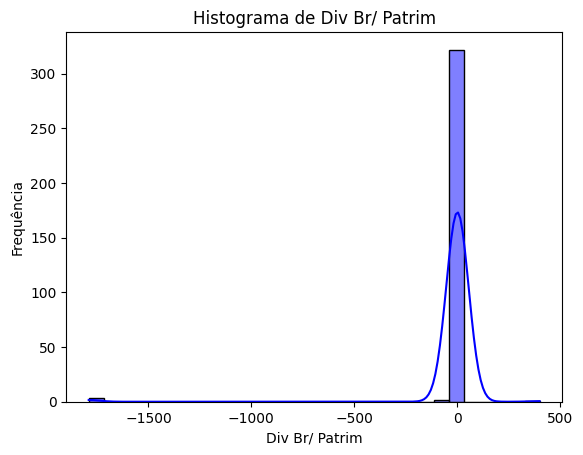

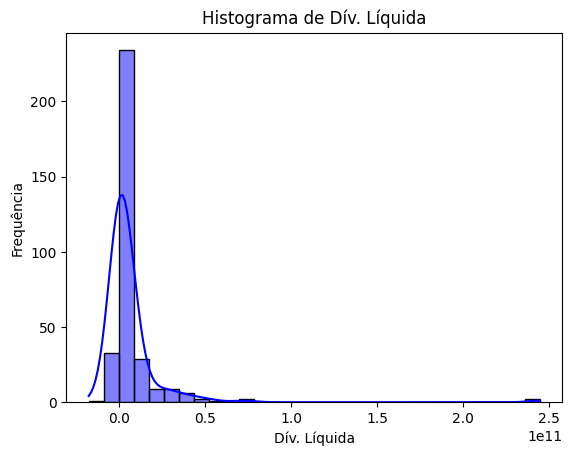

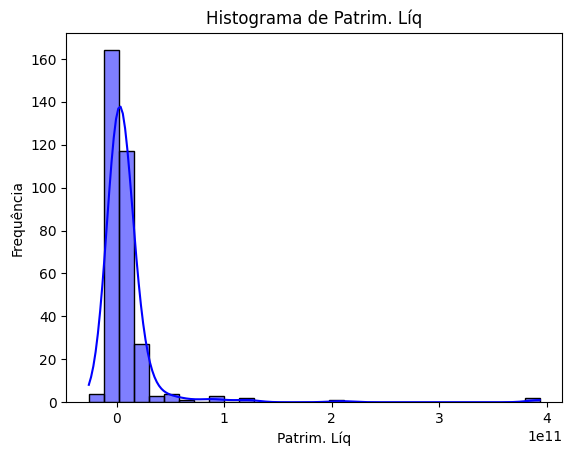

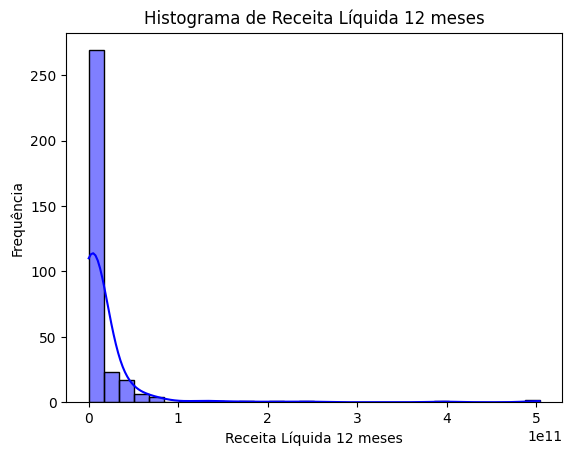

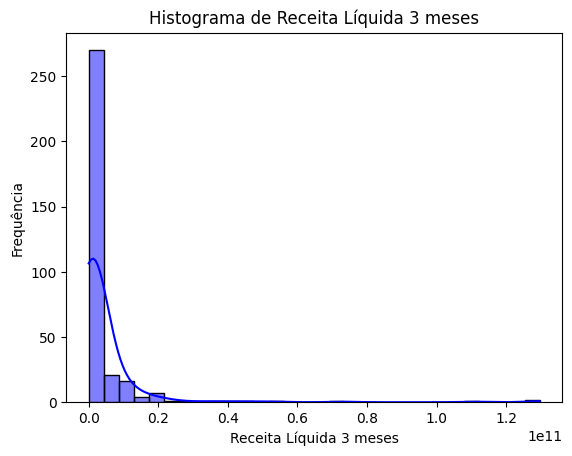

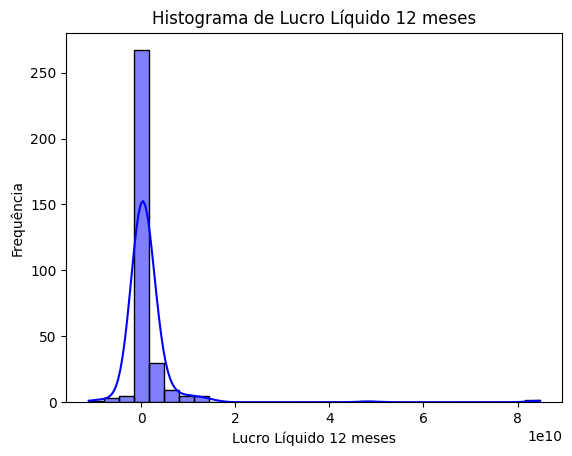

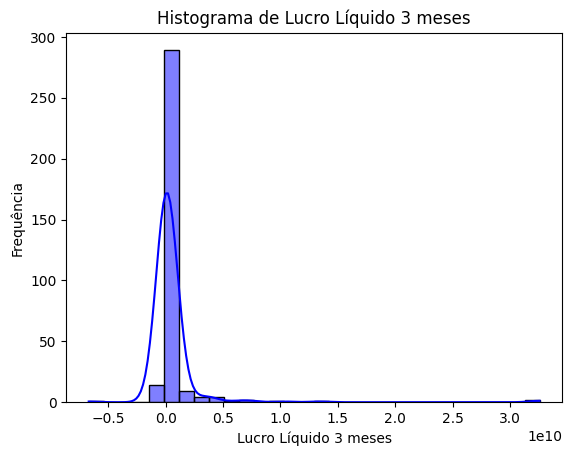

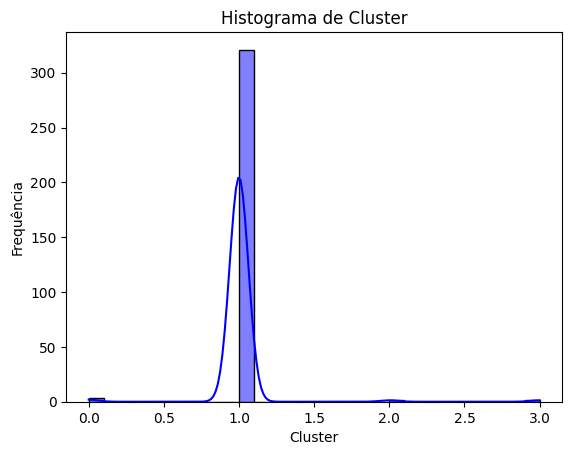

In [38]:
for var in df_limpo.columns[3:]:
    plt.figure()
    sns.histplot(df_limpo[var], kde=True, bins=30, color='blue')
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frequência')
    plt.show()

In [39]:
def identificar_outliers(coluna):
    Q1 = coluna.quantile(0.25)
    Q3 = coluna.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return (coluna < limite_inferior) | (coluna > limite_superior)

for var in df_limpo.columns[3:]:
    mask_outliers = identificar_outliers(df_limpo[var])
    if mask_outliers.any():  # Apenas se houver outliers
        outliers = df_limpo.loc[mask_outliers, ['Papel', var]]
        print(f"\nOutliers em {var}:")
        print(outliers)



Outliers em Vol $ méd (2m):
      Papel  Vol $ méd (2m)
3     ABEV3       477091000
73    AZUL4       109165000
75    B3SA3       626066000
151   BRAV3       190407000
153   BRFS3       253153000
201   CCRO3       128929000
242   CMIG4       168540000
259   CPLE6       188192000
267   CRFB3       111208000
278   CSAN3       168479000
281   CSNA3       109087000
304   CYRE3       156697000
362   ELET3       365906000
374   EMBR3       335380000
380   ENEV3       108750000
381  ENGI11       131969000
396   EQTL3       299702000
451   GGBR4       287031000
457   GOAU4       102874000
469   HAPV3       283102000
479   HYPE3       124859000
511   ITSA4       284930000
517   JBSS3       303034000
526  KLBN11       131745000
561   LREN3       257644000
586   MGLU3       275653000
610   MRFG3       184805000
616   MRVE3       101553000
627   MULT3       103264000
642   NTCO3       150821000
672   PETR3       403513000
673   PETR4      1293210000
696   POMO4       102244000
707   PRIO3       3

Observando os outliers, alguns chamam mais atenção que outros. Por exemplo, observamos valores elevados nos indicadores P/L, ROE e P/VP, que podem ser explicados em casos em que o denominador, isto é, o lucro para o primeiro e o valor patrimonial para os dois últimos, está próximo de zero. Além disso, valorizações discrepantes como a da empresa AMBP3 de 656% em 12 meses podem ser explicadas por fatos relevantes que ocorreram no período.

Ao todo, não acredito que nenhum dos outliers sejam provenientes de erros de documentação no site e, portanto, permanecerão na análise.

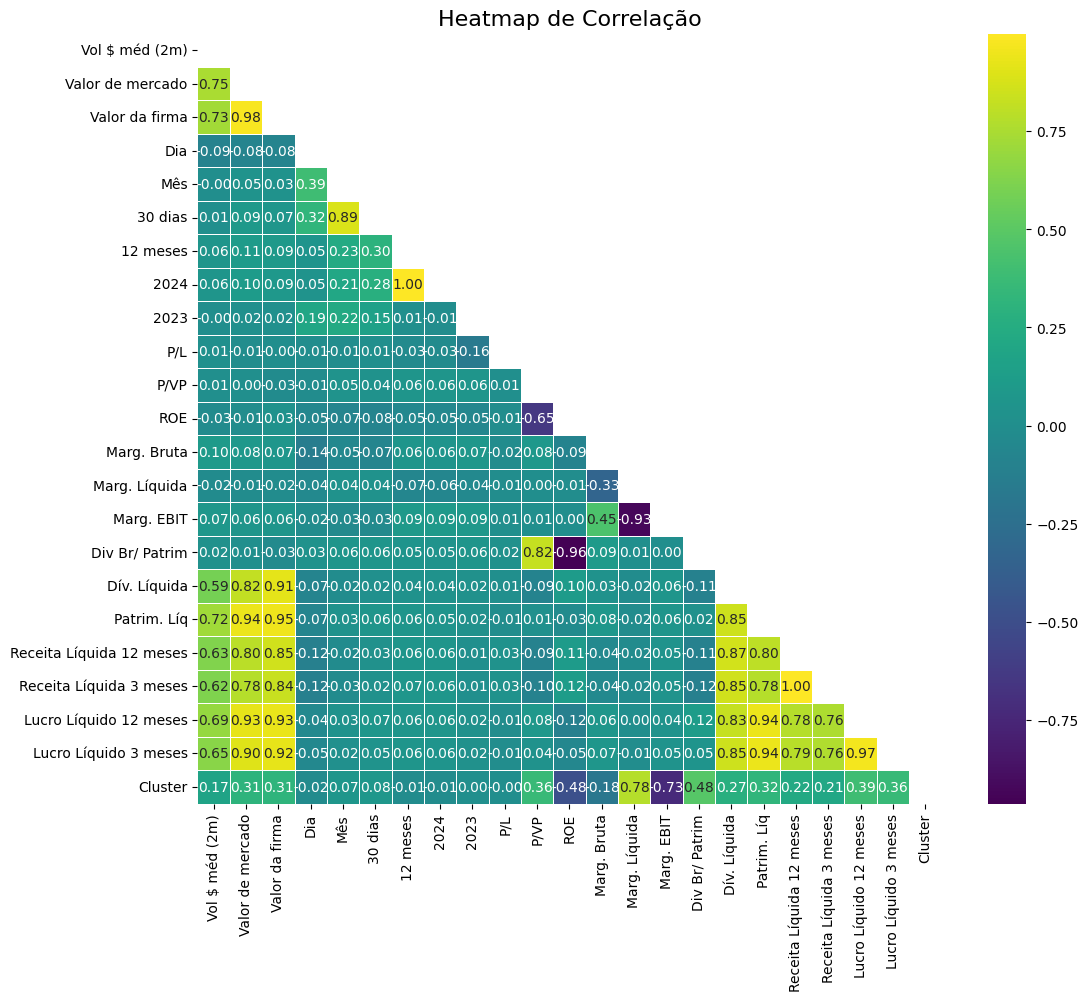

In [42]:
mask = np.triu(np.ones_like(df_limpo.iloc[:,3:].corr(), dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(df_limpo.iloc[:,3:].corr(),
            mask = mask,
            annot=True,
            fmt=".2f", cmap="viridis", cbar=True,
            linewidth = 0.5)

# Configurando o título
plt.title("Heatmap de Correlação", fontsize=16)
plt.show()

Podemos ver, na figura acima que muitas das variáveis estão altamente correlacionadas com outras. Assim, serão removidas algumas covariáveis do banco de dados de modo a prezar pela parcimônia.

In [44]:
# colunas a serem removidas
cols = ['Valor da firma', 'Mês',
        '2024', 'Div Br/ Patrim',
        'Marg. EBIT', 'Dív. Líquida',
        'Patrim. Líq', 'Receita Líquida 3 meses',
        'Lucro Líquido 3 meses', 'Lucro Líquido 12 meses']

df_limpo2 = df_limpo.drop(columns = cols)
df_limpo2.head()

Papel                                     Setor  \
0   AALR3  Serv.Méd.Hospit. Análises e Diagnósticos   
3   ABEV3                                   Bebidas   
11  AERI3                   Máquinas e Equipamentos   
21  AGRO3                              Agropecuária   
22  AGXY3                              Agropecuária   

                                    Subsetor  Vol $ méd (2m)  \
0   Serv.Méd.Hospit. Análises e Diagnósticos          222497   
3                   Cervejas e Refrigerantes       477091000   
11                 Máq. e Equip. Industriais         4740510   
21                               Agricultura         6112920   
22                               Agricultura          955057   

    Valor de mercado   Dia  30 dias  12 meses   2023    P/L  P/VP   ROE  \
0         1040980000  0.00   -30.71    -13.81 -51.85  -6.31  0.91 -14.4   
3       190195000000 -0.58     0.68     -7.80  -1.27  13.64  1.94  14.2   
11         516219000 -0.12    47.34    -57.60 -20.35  -3.75  0.50 -13.3   
21        2288810000 -1.20    -6.15     -9.41  -0.23   7.78  1.01  13.0   
22         117090000  0.00    17.95    -87.57 -62.97  -0.23  0.17 -72.8   

    Marg. Bruta  Marg. Líquida  Receita Líquida 12 meses  Cluster  
0          30.4          -12.9                1204510000        1  
3          51.0           17.4               82406500000        1  
11         15.1           -8.8                1564970000        1  
21         34.9           23.9                1230140000        1  
22          9.2           -7.0                7434280000        1

Com as colunas restantes, iremos avaliar a relação de cada variável com as demais.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable h

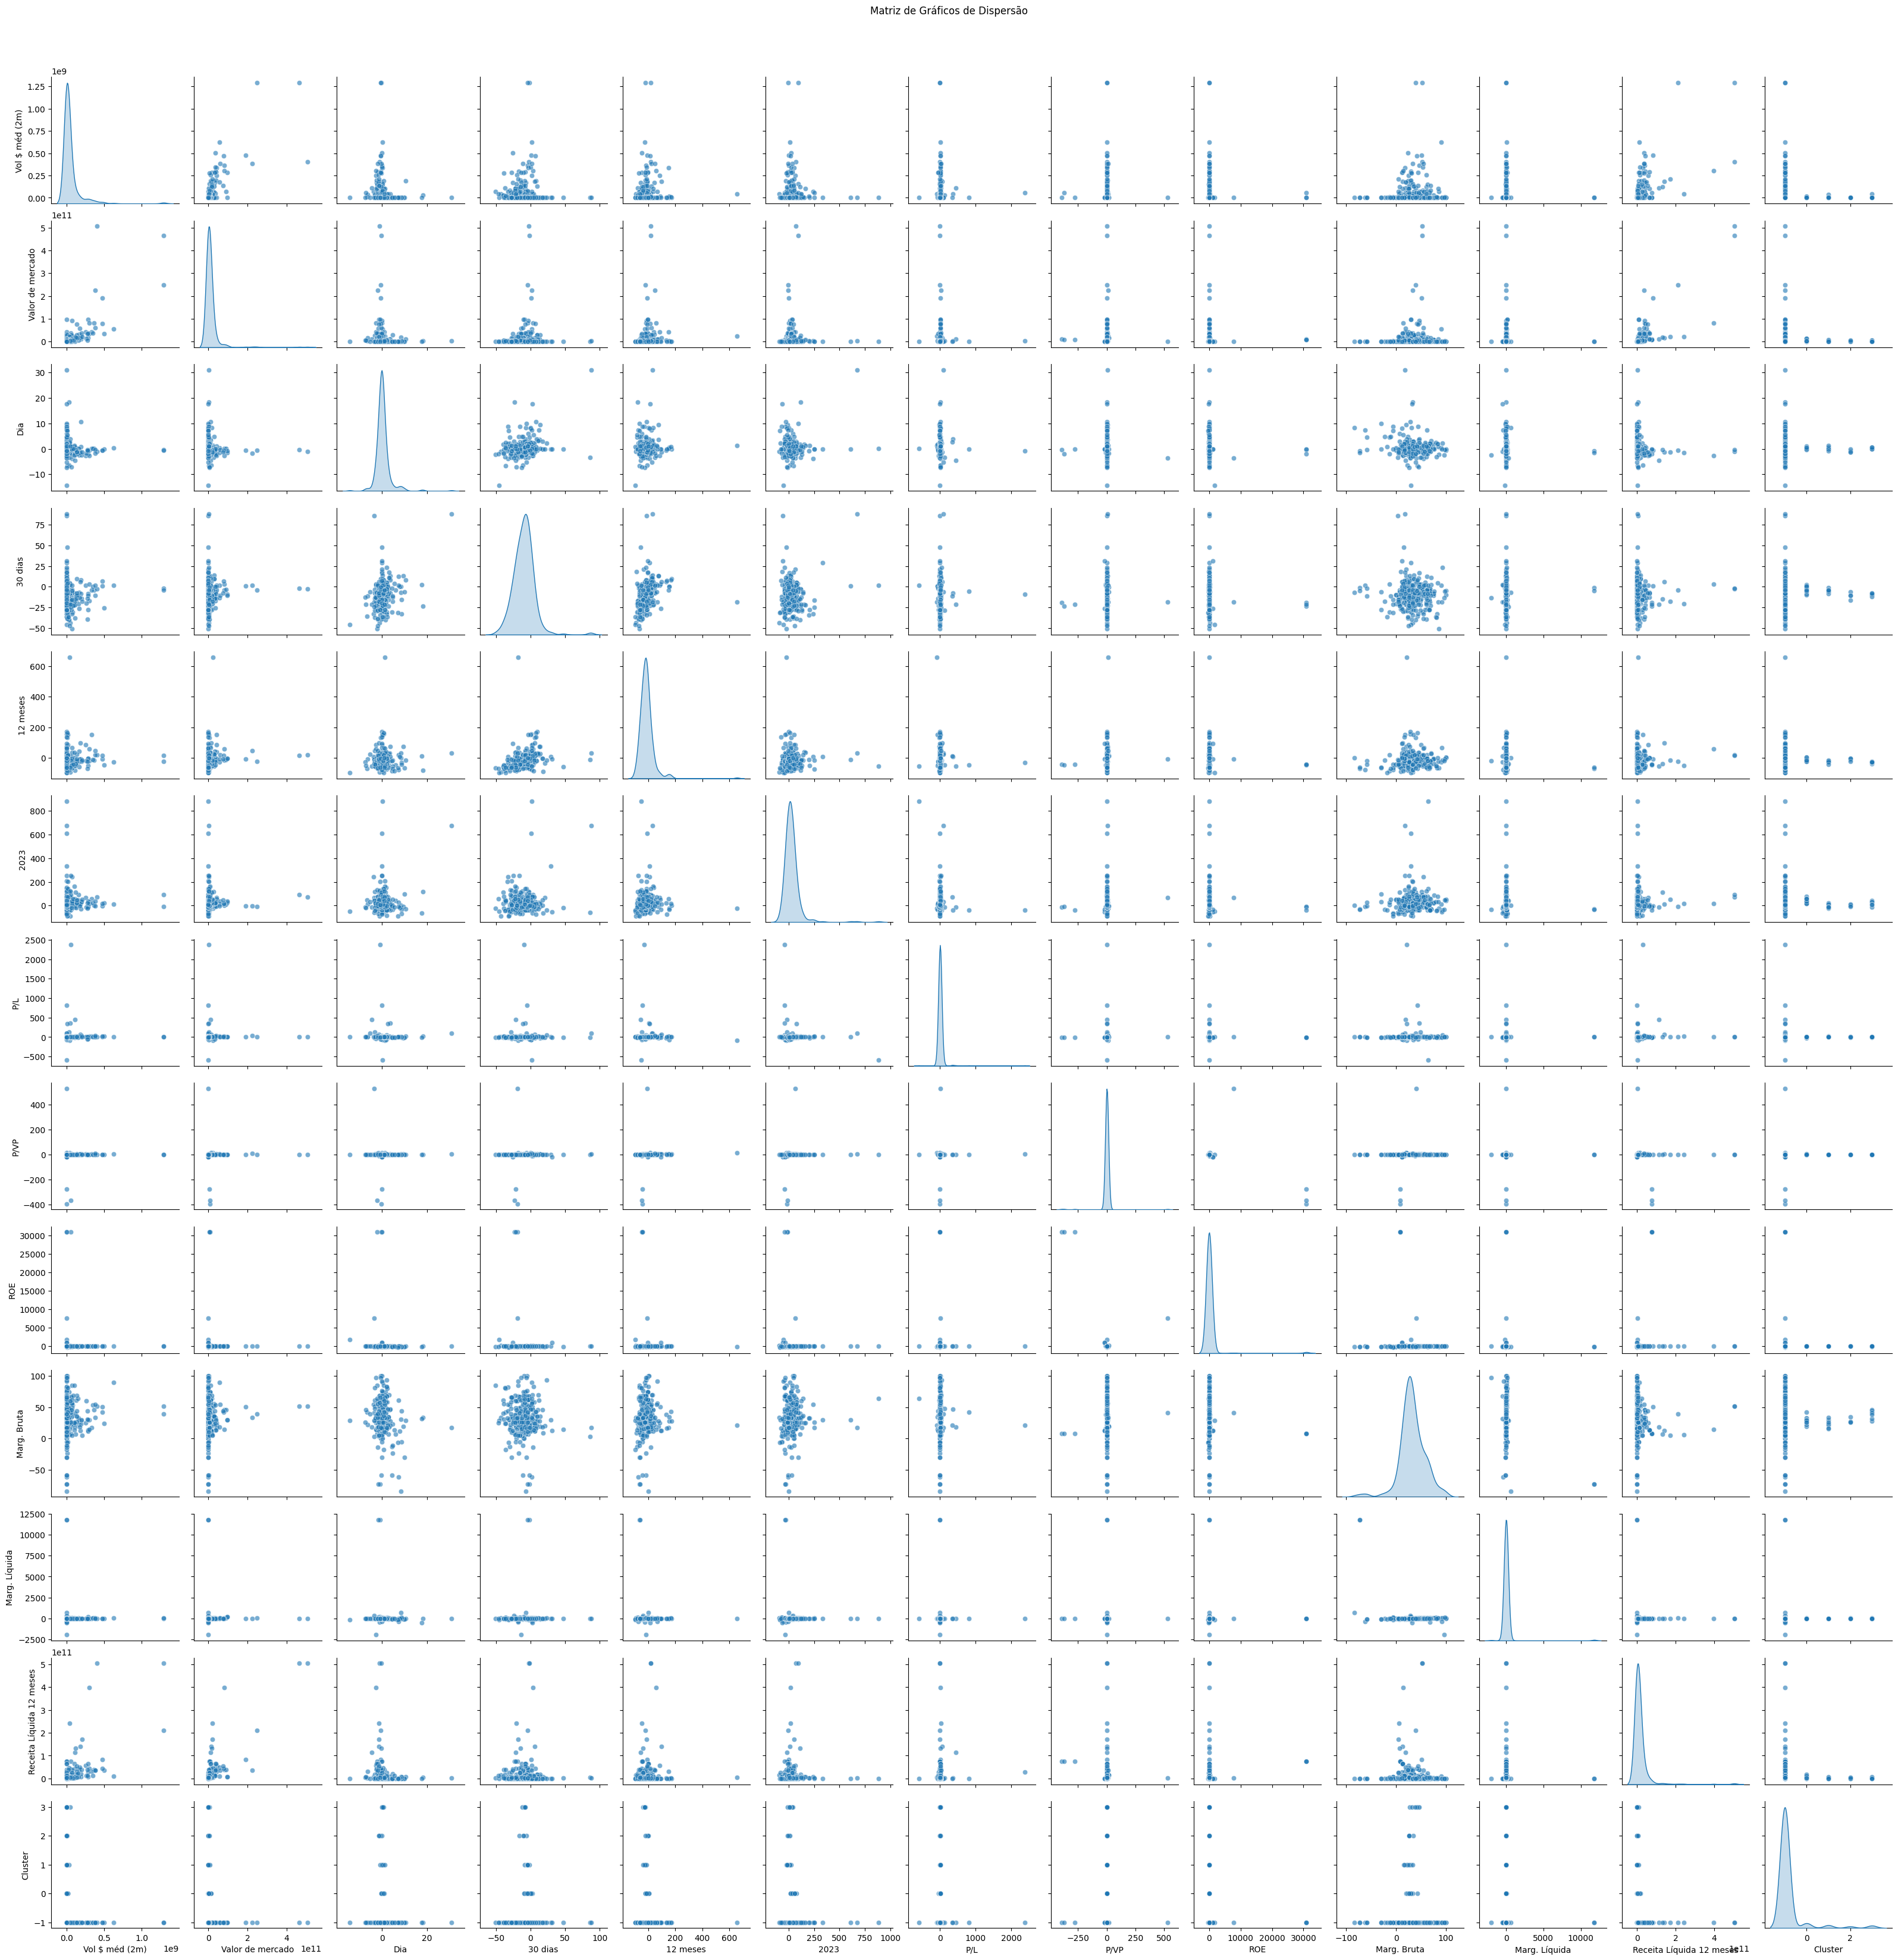

In [55]:
sns.pairplot(df_limpo2.iloc[:,3:], plot_kws={'alpha': 0.6}, diag_kind='kde', palette='viridis')
plt.suptitle('Matriz de Gráficos de Dispersão', y=1.02)
plt.show()

Com base nos gráficos acima, pode-se notar indícios de:


*   Uma correlação positiva com uma nuvem de pontos coesa para as variáveis retorno da ação nos últimos 12 meses (12 meses) e no último mês (30 dias), o que já era esperado;
*   Uma correlação positiva com uma nuvem de pontos coesa para receita líquida nos últimos 12 meses e o valor de mercado e volume de negociações (Vol $ méd (2m)), o que também é esperado.

No geral, não foi possível observar relações marcantes entre as variáveis do banco de dados.



Dado que o conjunto de dados possui um número relevante de outliers, é possível que para as observações não discrepantes seja possível observar relações mais interessantes entre as variáveis.

In [56]:
df_limpo3 = df_limpo2
for var in df_limpo2.columns[3:]:
    mask_outliers = identificar_outliers(df_limpo2[var])
    if mask_outliers.any():  # Apenas se houver outliers
        df_limpo3 = df_limpo3[~mask_outliers]

print(df_limpo3.shape)

(121, 16)


<ipython-input-56-2c1c83d31922>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_limpo3 = df_limpo3[~mask_outliers]
<ipython-input-56-2c1c83d31922>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_limpo3 = df_limpo3[~mask_outliers]
<ipython-input-56-2c1c83d31922>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_limpo3 = df_limpo3[~mask_outliers]
<ipython-input-56-2c1c83d31922>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_limpo3 = df_limpo3[~mask_outliers]
<ipython-input-56-2c1c83d31922>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_limpo3 = df_limpo3[~mask_outliers]
<ipython-input-56-2c1c83d31922>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_limpo3 = df_limpo3[~mask_outliers]
<ipython-input-56-2c1c83d31922>:5: UserWarning: Boolean Series key will be reindexed to match 

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable h

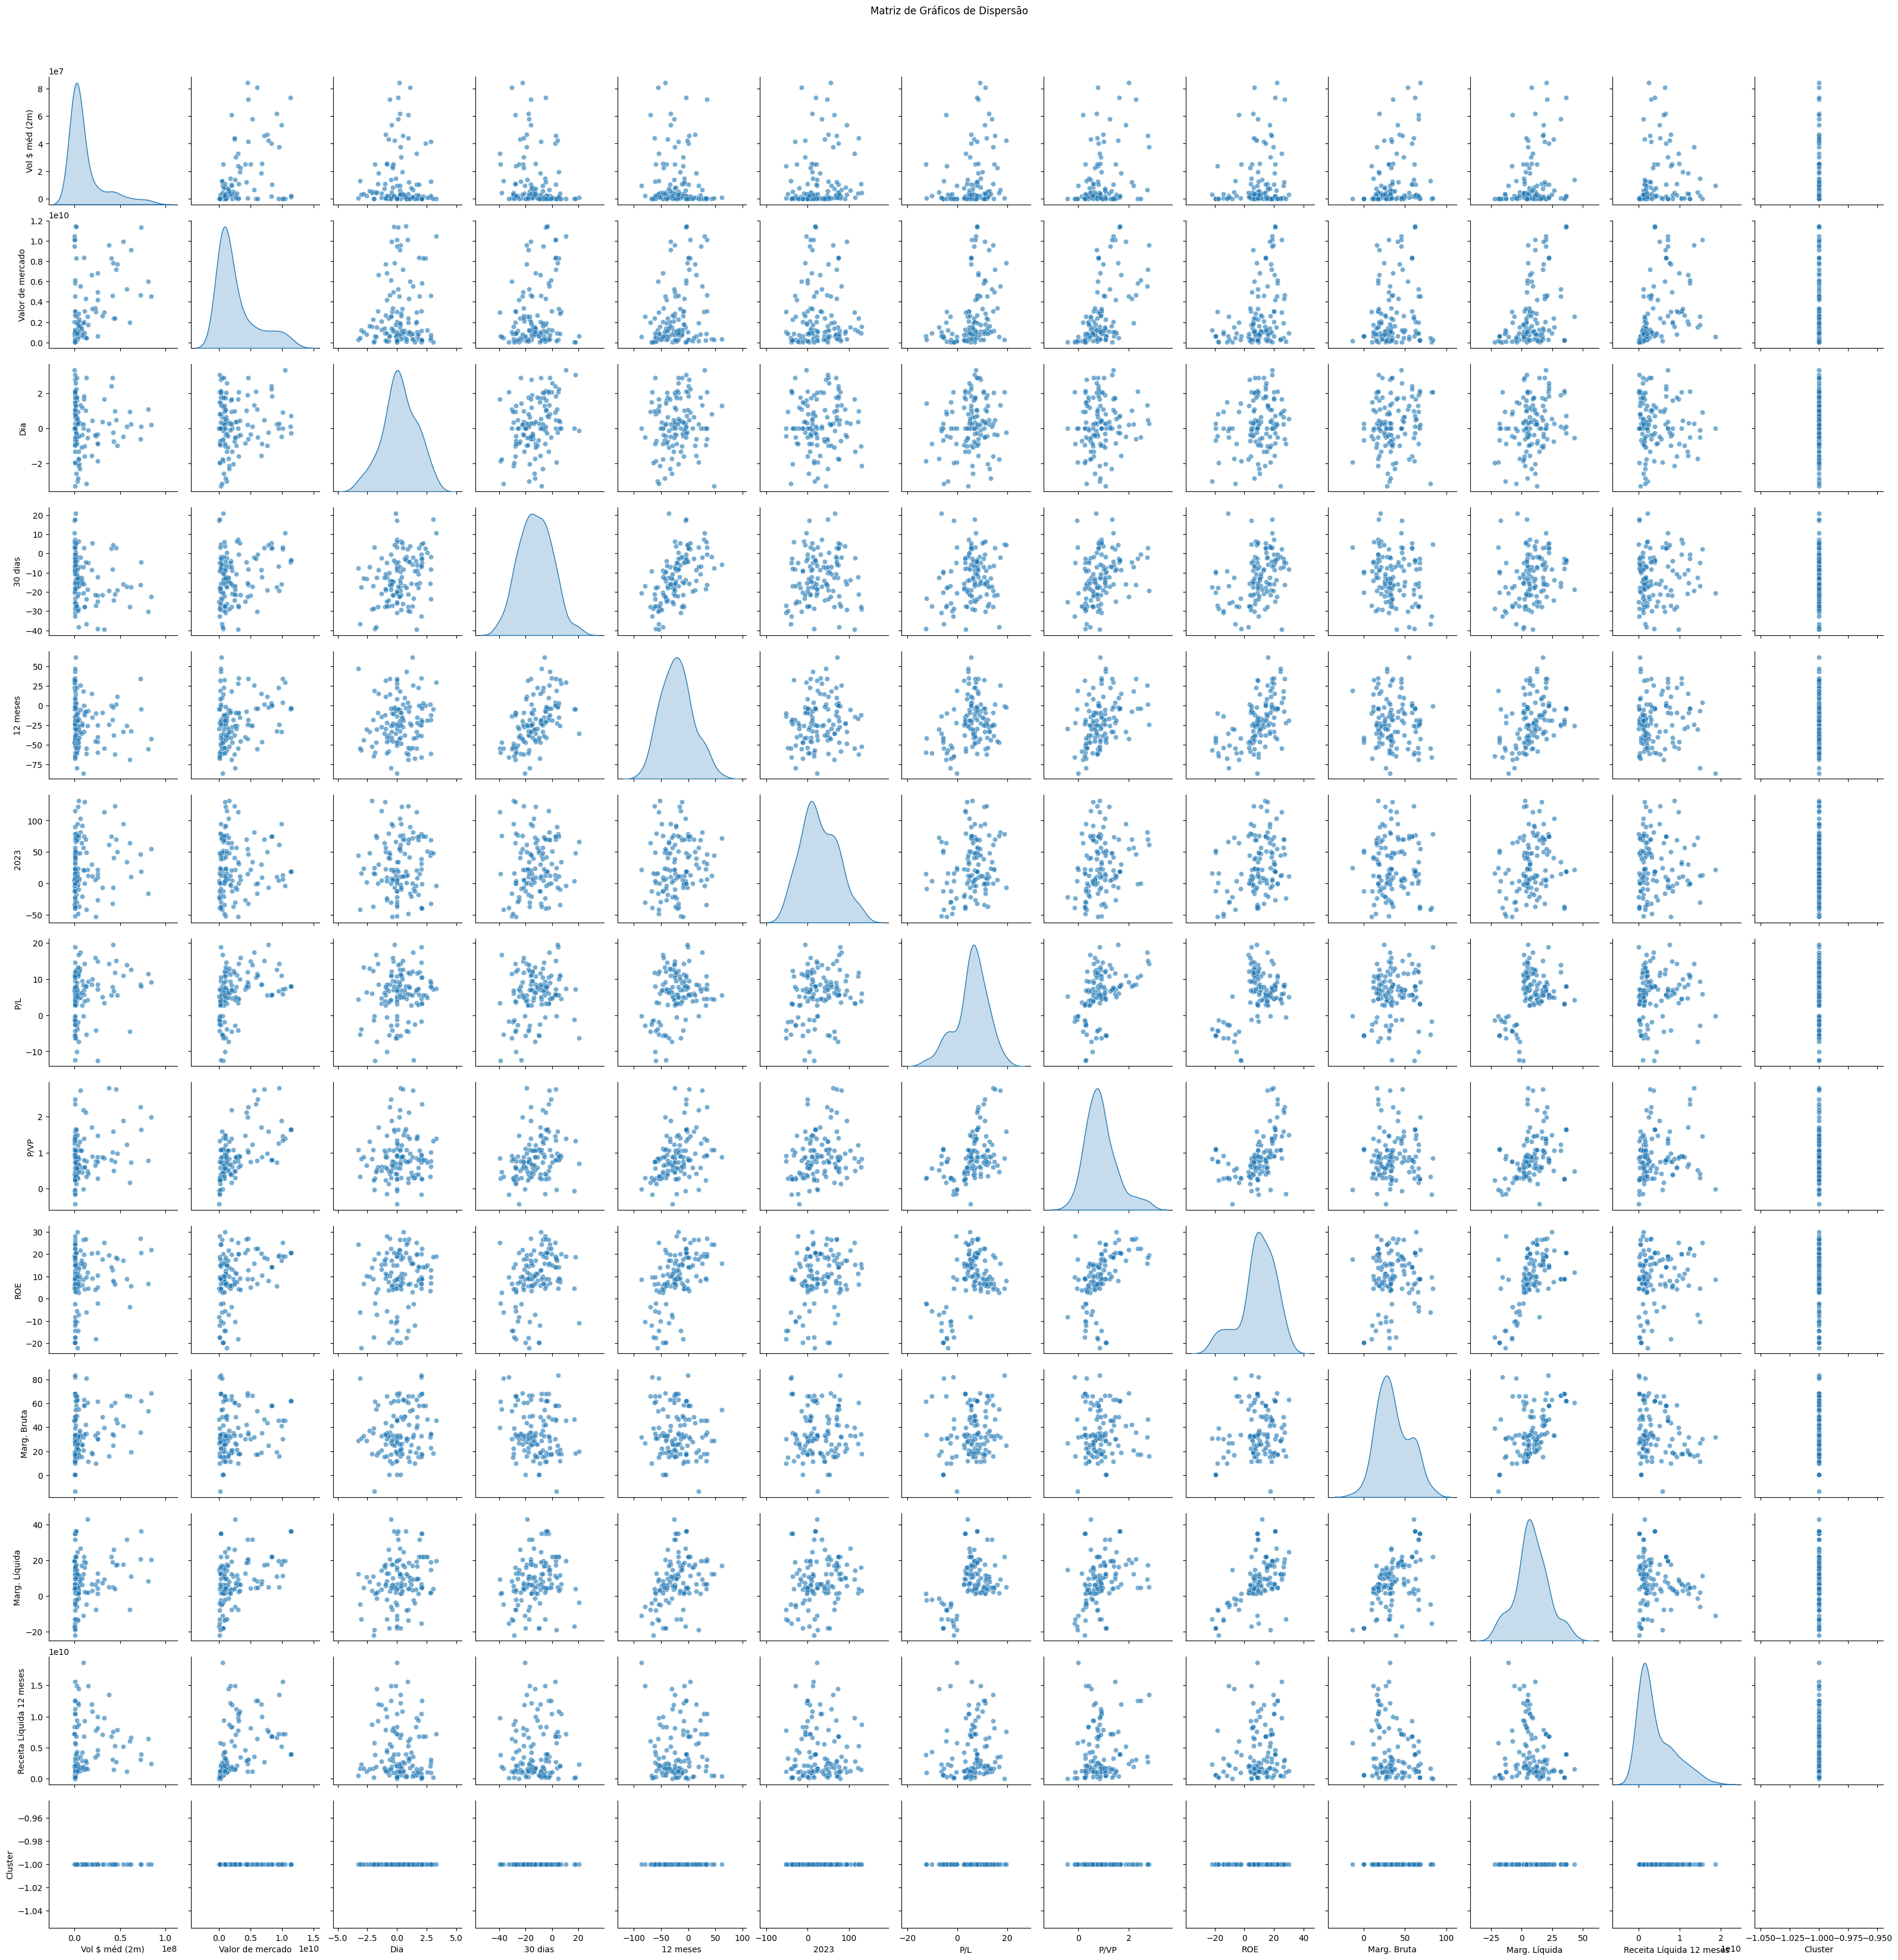

In [57]:
sns.pairplot(df_limpo3.iloc[:,3:], plot_kws={'alpha': 0.6}, diag_kind='kde', palette='viridis')
plt.suptitle('Matriz de Gráficos de Dispersão', y=1.02)
plt.show()

Agora, com os outliers removidos, visualização das nuvens de pontos se tornou melhor, porém ainda não é possível observar nenhuma relação forte entre as variáveis. A visualização das variáveis ROE (retorno sobre o patrimônio), P/PL (preço sobre patrimônio líquido) e P/L (preço sobre lucro) melhoram drasticamente e é possível observar indícios de uma certa relação positiva entre estas variáveis e os retornos em 30 dias e 12 meses e a margem líquida. E o mesmo pode ser observado pelo estimador de correlação de Pearson abaixo.

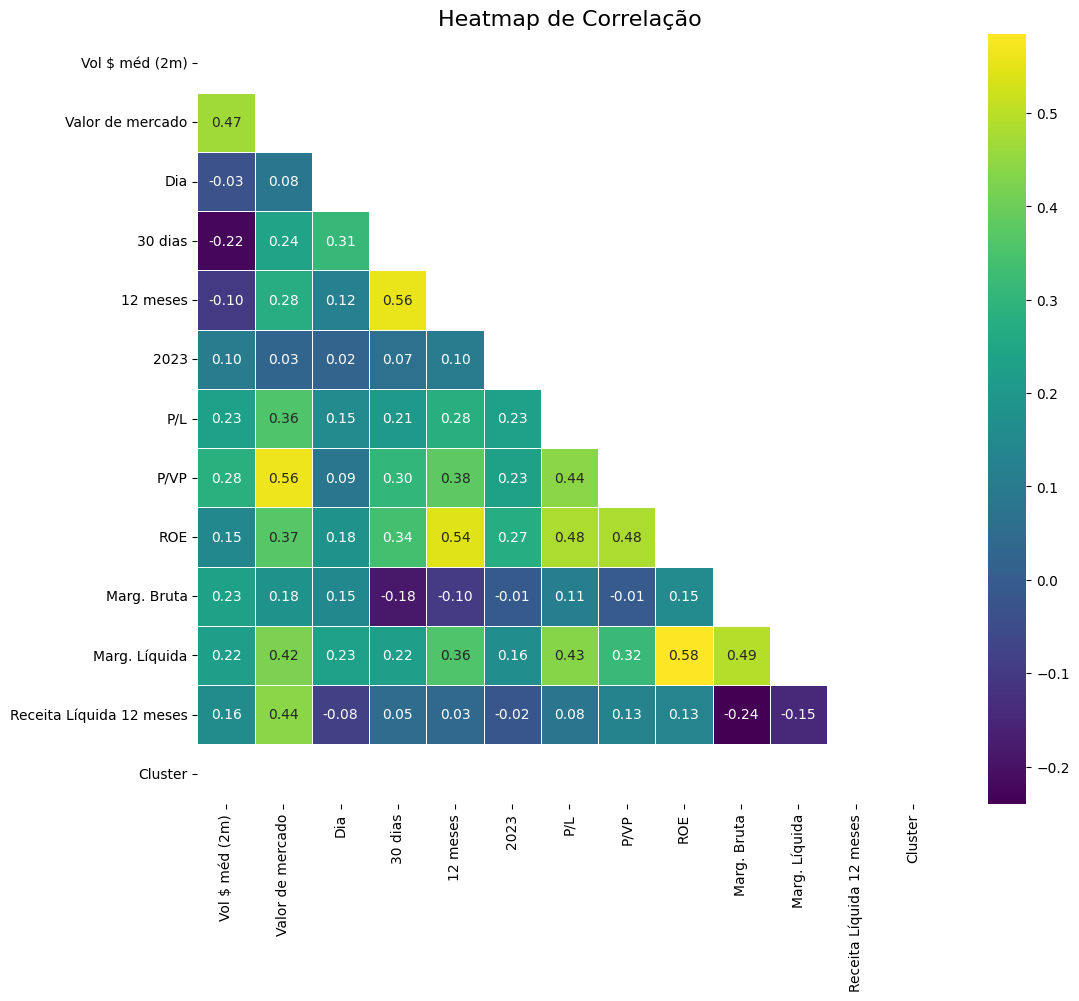

In [58]:
mask = np.triu(np.ones_like(df_limpo3.iloc[:,3:].corr(), dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(df_limpo3.iloc[:,3:].corr(),
            mask = mask,
            annot=True,
            fmt=".2f", cmap="viridis", cbar=True,
            linewidth = 0.5)

# Configurando o título
plt.title("Heatmap de Correlação", fontsize=16)
plt.show()

# Análise de agrupamento

Por fim, foi realizada uma análise de agrupamento para avaliar a presença de padrões nos dados.

## K-means com outliers


In [45]:
# selecionar apenas colunas numericas
cols = df_limpo2.iloc[:,3:].columns

scaler = StandardScaler()
df_norm = scaler.fit_transform(df_limpo2[cols])

df_norm

array([[-0.3667419 , -0.26107811, -0.10917966, ..., -0.09077274,
        -0.29364809, -0.04599085],
       [ 3.20271904,  3.93844173, -0.28430898, ..., -0.05814742,
         1.29382245, -0.04599085],
       [-0.33292362, -0.27272864, -0.14541331, ..., -0.0863581 ,
        -0.28660123, -0.04599085],
       ...,
       [-0.36809387, -0.26075219,  0.20786481, ..., -0.07225276,
        -0.25314786, -0.04599085],
       [-0.03785297, -0.23078982,  0.18370904, ..., -0.07268346,
        -0.21328573, -0.04599085],
       [-0.35235418, -0.26368103, -0.37187365, ..., -0.07914392,
        -0.23247391, -0.04599085]])

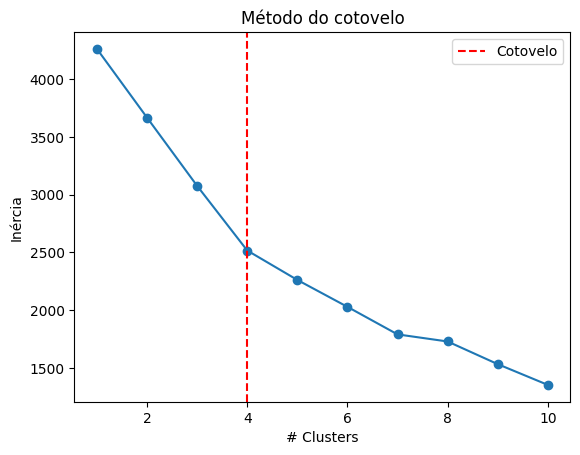

In [46]:
inercia = []
for k in range(1, 11):  # Testando de 1 a 10 clusters
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_norm)
    inercia.append(kmeans.inertia_)

cotovelo = KneeLocator(range(1,11), inercia, curve='convex', direction='decreasing').elbow

# Plotando o gráfico do cotovelo
plt.plot(range(1, 11), inercia, marker='o')
plt.xlabel('# Clusters')
plt.ylabel('Inércia')
plt.title('Método do cotovelo')
plt.axvline(x=cotovelo, color='r', linestyle='--', label='Cotovelo')
plt.legend()
plt.show()

Número de clusters = 4

In [47]:
# Ajustando o K-means com o número de clusters escolhido (k=4)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
df_limpo2['Cluster'] = kmeans.fit_predict(df_norm)

# Exibindo as primeiras linhas do DataFrame com os clusters atribuídos
df_limpo2.head()

Papel                                     Setor  \
0   AALR3  Serv.Méd.Hospit. Análises e Diagnósticos   
3   ABEV3                                   Bebidas   
11  AERI3                   Máquinas e Equipamentos   
21  AGRO3                              Agropecuária   
22  AGXY3                              Agropecuária   

                                    Subsetor  Vol $ méd (2m)  \
0   Serv.Méd.Hospit. Análises e Diagnósticos          222497   
3                   Cervejas e Refrigerantes       477091000   
11                 Máq. e Equip. Industriais         4740510   
21                               Agricultura         6112920   
22                               Agricultura          955057   

    Valor de mercado   Dia  30 dias  12 meses   2023    P/L  P/VP   ROE  \
0         1040980000  0.00   -30.71    -13.81 -51.85  -6.31  0.91 -14.4   
3       190195000000 -0.58     0.68     -7.80  -1.27  13.64  1.94  14.2   
11         516219000 -0.12    47.34    -57.60 -20.35  -3.75  0.50 -13.3   
21        2288810000 -1.20    -6.15     -9.41  -0.23   7.78  1.01  13.0   
22         117090000  0.00    17.95    -87.57 -62.97  -0.23  0.17 -72.8   

    Marg. Bruta  Marg. Líquida  Receita Líquida 12 meses  Cluster  
0          30.4          -12.9                1204510000        1  
3          51.0           17.4               82406500000        1  
11         15.1           -8.8                1564970000        1  
21         34.9           23.9                1230140000        1  
22          9.2           -7.0                7434280000        1

In [48]:
print('Número de empresas em cada cluster:')
print(df_limpo2['Cluster'].value_counts())

Número de empresas em cada cluster:
Cluster
1    320
0      3
2      3
3      2
Name: count, dtype: int64


In [49]:
sil_score = silhouette_score(df_norm, df_limpo2['Cluster'])
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.7803433184328186


In [50]:
score1 = davies_bouldin_score(df_norm, df_limpo2['Cluster'])
print(f'Davies Bouldin Score: {score1}')

Davies Bouldin Score: 0.40437478730076654


Um valor próximo de 1 para o indicador silhouette indica que os clusters formados pelo algoritmo K-means estão bem definidos e são bastante distintos uns dos outros. Já para o Davies Bouldin, quanto mais perto de zero mais dissimilares os clusters são entre si e, portanto, melhor seria o ajuste.

No entanto, sabemos que o ajuste não foi o melhor, dado que as classes estão extremamente desbalanceadas e quase todas as observações foram classificadas como pertencentes ao cluster 1.

## K-means sem outliers

In [68]:
# selecionar apenas colunas numericas
cols = df_limpo3.iloc[:,3:].columns

scaler = StandardScaler()
df_norm = scaler.fit_transform(df_limpo3[cols])

df_norm

array([[-0.58803907, -0.54052749, -0.17298365, ..., -1.63272701,
        -0.72303398,  0.        ],
       [-0.55444627, -0.6733272 , -0.58864514, ..., -0.43084709,
         0.3047096 ,  0.        ],
       [ 0.71065715, -0.67076745, -1.48337411, ..., -0.5380211 ,
        -0.10845797,  0.        ],
       ...,
       [-0.59740612, -0.5357817 ,  0.5667529 , ..., -0.3160178 ,
        -0.23469124,  0.        ],
       [ 1.69063408, -0.09949219,  0.51039202, ..., -0.34663895,
         0.24595742,  0.        ],
       [-0.48835524, -0.57842916, -0.78590822, ..., -0.80595611,
         0.01459065,  0.        ]])

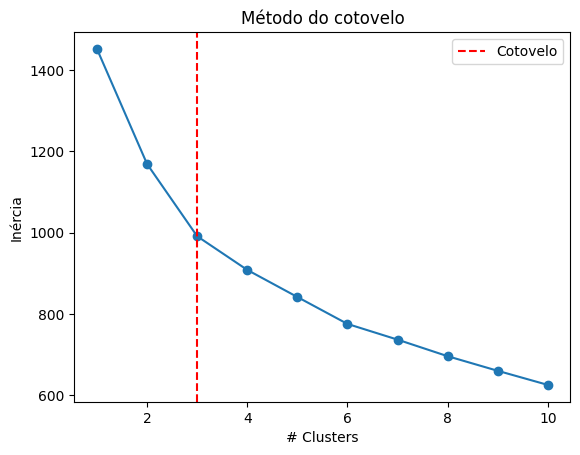

In [69]:
inercia = []
for k in range(1, 11):  # Testando de 1 a 10 clusters
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_norm)
    inercia.append(kmeans.inertia_)

cotovelo = KneeLocator(range(1,11), inercia, curve='convex', direction='decreasing').elbow

# Plotando o gráfico do cotovelo
plt.plot(range(1, 11), inercia, marker='o')
plt.xlabel('# Clusters')
plt.ylabel('Inércia')
plt.title('Método do cotovelo')
plt.axvline(x=cotovelo, color='r', linestyle='--', label='Cotovelo')
plt.legend()
plt.show()

Número de clusters = 3

In [70]:
# Ajustando o K-means com o número de clusters escolhido (k=3)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
df_limpo3['Cluster'] = kmeans.fit_predict(df_norm)

# Exibindo as primeiras linhas do DataFrame com os clusters atribuídos
df_limpo3.head()

Papel                                     Setor  \
0   AALR3  Serv.Méd.Hospit. Análises e Diagnósticos   
27  ALLD3                                  Comércio   
47  ANIM3                                  Diversos   
67  AURE3                          Energia Elétrica   
74  AZZA3                                  Comércio   

                                    Subsetor  Vol $ méd (2m)  \
0   Serv.Méd.Hospit. Análises e Diagnósticos          222497   
27                          Eletrodomésticos          870250   
47                     Serviços Educacionais        25264600   
67                          Energia Elétrica        61797300   
74             Tecidos, Vestuário e Calçados        81094600   

    Valor de mercado   Dia  30 dias  12 meses   2023    P/L  P/VP   ROE  \
0         1040980000  0.00   -30.71    -13.81 -51.85  -6.31  0.91 -14.4   
27         630195000 -0.59   -14.23     14.29  39.90   4.05  0.41  10.2   
47         638113000 -1.86   -39.23    -59.55  15.54 -12.49  0.28  -2.2   
67        9138290000  0.23   -17.69    -32.58  11.03  12.64  0.73   5.7   
74        6017120000  1.08   -30.37    -55.02 -15.39  11.34  0.77   6.7   

    Marg. Bruta  Marg. Líquida  Receita Líquida 12 meses  Cluster  
0          30.4          -12.9                1204510000        2  
27         11.8            2.8                5564430000        1  
47         61.3            1.4                3811680000        2  
67         19.1           11.0                6597790000        0  
74         53.6            8.2                6400540000        0

In [71]:
print('Número de empresas em cada cluster:')
print(df_limpo3['Cluster'].value_counts())

Número de empresas em cada cluster:
Cluster
1    71
0    27
2    23
Name: count, dtype: int64


In [72]:
sil_score = silhouette_score(df_norm, df_limpo3['Cluster'])
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.19291923583718631


In [73]:
score1 = davies_bouldin_score(df_norm, df_limpo3['Cluster'])
print(f'Davies Bouldin Score: {score1}')

Davies Bouldin Score: 1.7631330068099362


Neste caso, obtivemos valores piores para o Silhouette e para o Davies Bouldin, no entanto, observamos que as classes estão mais bem equilibradas.

In [76]:
print("Média de cada variável numérica por cluster:")
print(df_limpo3.iloc[:,3:].groupby('Cluster').mean())
print('\n --- \n')
print("Frequência de cada variável categórica por cluster")
for col in ['Setor', 'Subsetor']:
    print(f"\nFrequência de {col} por cluster:")
    print(df_limpo3.groupby('Cluster')[col].value_counts())

Média de cada variável numérica por cluster:
         Vol $ méd (2m)  Valor de mercado       Dia    30 dias   12 meses  \
Cluster                                                                     
0          3.024534e+07      7.826818e+09  0.585556  -6.720741  -4.533704   
1          6.087604e+06      1.392831e+09  0.284366 -12.219155 -16.867887   
2          6.525220e+06      7.849994e+08 -0.273478 -19.646522 -48.815652   

              2023       P/L      P/VP        ROE  Marg. Bruta  Marg. Líquida  \
Cluster                                                                         
0        32.138889  9.606296  1.591111  17.337037    42.255556      17.474074   
1        36.039014  7.621972  0.776761  12.276056    34.370423      10.478873   
2         1.803043 -4.480435  0.438696  -9.534783    32.978261      -8.521739   

         Receita Líquida 12 meses  
Cluster                            
0                    6.761511e+09  
1                    3.484321e+09  
2                  

Ao todo podemos caracterizar cada um dos clusters da seguinte forma:


*   **Cluster 1:** possui o maior volume médio de negociações nos últimos 2 meses, o maior valor de mercado, os maiores retornos em todos os períodos (um dia, um mês, um ano e 2023), os maiores valores de ROE, P/L e P/VL, além de ter as maiores margens e maiores receitas.
*   **Cluster 2:** possui o segundo maior valor de mercado, os segundos maiores retornos em todos os períodos e os segundos maiores valores para as demais variáveis, com exceção da receita líquida nos últimos 12 meses.
*   **Cluster 3:** no geral, possui as médias mais baixas para quase todas as variáveis.





## DBSCAN com outliers

(Density-Based Spatial Clustering of Applications with Noise)

In [ ]:
# selecionar apenas colunas numericas
cols = df_limpo2.iloc[:,3:].columns

scaler = StandardScaler()
df_norm = scaler.fit_transform(df_limpo2[cols])

df_norm

In [52]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_limpo2['Cluster'] = dbscan.fit_predict(df_norm)

df_limpo2.head()

Papel                                     Setor  \
0   AALR3  Serv.Méd.Hospit. Análises e Diagnósticos   
3   ABEV3                                   Bebidas   
11  AERI3                   Máquinas e Equipamentos   
21  AGRO3                              Agropecuária   
22  AGXY3                              Agropecuária   

                                    Subsetor  Vol $ méd (2m)  \
0   Serv.Méd.Hospit. Análises e Diagnósticos          222497   
3                   Cervejas e Refrigerantes       477091000   
11                 Máq. e Equip. Industriais         4740510   
21                               Agricultura         6112920   
22                               Agricultura          955057   

    Valor de mercado   Dia  30 dias  12 meses   2023    P/L  P/VP   ROE  \
0         1040980000  0.00   -30.71    -13.81 -51.85  -6.31  0.91 -14.4   
3       190195000000 -0.58     0.68     -7.80  -1.27  13.64  1.94  14.2   
11         516219000 -0.12    47.34    -57.60 -20.35  -3.75  0.50 -13.3   
21        2288810000 -1.20    -6.15     -9.41  -0.23   7.78  1.01  13.0   
22         117090000  0.00    17.95    -87.57 -62.97  -0.23  0.17 -72.8   

    Marg. Bruta  Marg. Líquida  Receita Líquida 12 meses  Cluster  
0          30.4          -12.9                1204510000       -1  
3          51.0           17.4               82406500000       -1  
11         15.1           -8.8                1564970000       -1  
21         34.9           23.9                1230140000        2  
22          9.2           -7.0                7434280000       -1

In [54]:
print('Número de empresas em cada cluster:')
print(df_limpo2['Cluster'].value_counts())

Número de empresas em cada cluster:
Cluster
-1    299
 0     12
 1      7
 3      6
 2      4
Name: count, dtype: int64


Observamos que a maioria das empresas foi considerada como outlier (valor -1). O que indica que este ajuste também não foi bom.

In [53]:
mask_non_outliers = df_limpo2['Cluster'] != -1

# Avaliando a qualidade do clustering para os pontos não-outliers
sil_score = silhouette_score(df_norm[mask_non_outliers], df_limpo2.loc[mask_non_outliers, 'Cluster'])
print(f'Silhouette Score (sem outliers): {sil_score}')

Silhouette Score (sem outliers): 0.1978052467744282


## DBSCAN sem outliers

In [ ]:
# selecionar apenas colunas numericas
cols = df_limpo3.iloc[:,3:].columns

scaler = StandardScaler()
df_norm = scaler.fit_transform(df_limpo3[cols])

df_norm

In [65]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_limpo3['Cluster'] = dbscan.fit_predict(df_norm)

df_limpo3.head()

Papel                                     Setor  \
0   AALR3  Serv.Méd.Hospit. Análises e Diagnósticos   
27  ALLD3                                  Comércio   
47  ANIM3                                  Diversos   
67  AURE3                          Energia Elétrica   
74  AZZA3                                  Comércio   

                                    Subsetor  Vol $ méd (2m)  \
0   Serv.Méd.Hospit. Análises e Diagnósticos          222497   
27                          Eletrodomésticos          870250   
47                     Serviços Educacionais        25264600   
67                          Energia Elétrica        61797300   
74             Tecidos, Vestuário e Calçados        81094600   

    Valor de mercado   Dia  30 dias  12 meses   2023    P/L  P/VP   ROE  \
0         1040980000  0.00   -30.71    -13.81 -51.85  -6.31  0.91 -14.4   
27         630195000 -0.59   -14.23     14.29  39.90   4.05  0.41  10.2   
47         638113000 -1.86   -39.23    -59.55  15.54 -12.49  0.28  -2.2   
67        9138290000  0.23   -17.69    -32.58  11.03  12.64  0.73   5.7   
74        6017120000  1.08   -30.37    -55.02 -15.39  11.34  0.77   6.7   

    Marg. Bruta  Marg. Líquida  Receita Líquida 12 meses  Cluster  
0          30.4          -12.9                1204510000       -1  
27         11.8            2.8                5564430000       -1  
47         61.3            1.4                3811680000       -1  
67         19.1           11.0                6597790000       -1  
74         53.6            8.2                6400540000       -1

In [66]:
print('Número de empresas em cada cluster:')
print(df_limpo3['Cluster'].value_counts())

Número de empresas em cada cluster:
Cluster
-1    121
Name: count, dtype: int64


Observamos que a maioria das empresas foi considerada como outlier (valor -1). O que indica que este foi pior que o anterior.

# Conclusão

Neste trabalho foram extraídos dados de companhias de capital aberto por meio de técnicas de webscraping, foi feito um tratamento destes dados, uma análise descritiva e exploratório e, por fim, foram feitas análises de agrupamento por meio de diferentes modelos.

Durante a execução do trabalho, foram enfrentados diversos desafios, como a interpretação dos códigos em HTML, a seleção das melhores informações, a limpeza da base dados e como lidar com a presença de um vasto número de outliers.

No final, deu para entender melhor a representatividade de cada setor no mercado de capitais e como os diferentes indicadores se relacionam, mesmo que as conexões não tenham sido tão fortes. Depois de testar alguns modelos, o K-means com a exclusão dos outliers se destacou como o melhor, uma vez que ele permitiu extrair mais informações dos dados, comparado aos outros modelos.